# IPBME6UE: Problem Set 2 - Medical Image Processing

## Spring 2023

## Group Members

**Person 1:**

Henrik Sainio

**Person 2:**

Daniel Netzl

Welcome to Problem Set 2!

In this problem set, we will be exploring some fundamental concepts in digital image processing and will perform segmentation and classification of tumors and leisons in imaging.

Breast cancer (BC) is the most commonly diagnosed malignant disease and [the leading cause of cancer death in women in Austria](https://pubmed.ncbi.nlm.nih.gov/35487918/).

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, or at least in our course..."

Treat this as a mini-project. We highly encourage working with 1 other person.


## Problem 1: Image Segmentation (30 points)


Download the [segmentation dataset (~200 MB)](https://imcfhkrems.sharepoint.com/:u:/r/teams/LV_62825/Class%20Materials/Exercise%202/Dataset_BUSI_with_GT.zip?csf=1&web=1&e=fpNqjR).

The dataset is divided into benign, malignant, and normal ultrasound imaging with binary masking.

**a.** Your first task is to segment the images. You may use any of the segmentation algorithms we saw in class. You can ignore the tumor-type division and use all the images but keep track of the method's performance per tumor type for the report in the next section. For the adventurist in you, try using deep learning to generate an initial ROI and active contours to shape that initial ROI into the final segmentation contour. Evaluate your results using an appropriate segmentation metric compared to the ground-truth labels as the target.


In [117]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as io

from skimage import exposure, filters, morphology, restoration, feature, segmentation, transform
from tqdm import tqdm

# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'

# Load mammogram image and mask
img_path = os.path.join(data_dir, 'malignant\\malignant (1).png')
mask_path = os.path.join(data_dir, 'malignant\\malignant (1)_mask.png')
img = io.imread(img_path, as_gray=True)
mask_org = io.imread(mask_path, as_gray=True)

print(f'Img shape: {img.shape}, Mask shape: {mask_org.shape}')

Img shape: (598, 449), Mask shape: (598, 449)


In [118]:
def dice_coefficient(mask_true, mask_pred):
    """
    Computes the Dice coefficient between two binary masks.

    Parameters
    ----------
    mask_true : ndarray
        Ground-truth binary mask.
    mask_pred : ndarray
        Predicted binary mask.

    Returns
    -------
    float
        Dice coefficient between the two masks.
    """
    intersection = np.logical_and(mask_true, mask_pred)
    return 2 * intersection.sum() / (mask_true.sum() + mask_pred.sum())

def jaccard_index(mask_true, mask_pred):
    """
    Computes the Jaccard index between two binary masks.

    Parameters
    ----------
    mask_true : ndarray
        Ground-truth binary mask.
    mask_pred : ndarray
        Predicted binary mask.

    Returns
    -------
    float
        Jaccard index between the two masks.
    """
    intersection = np.logical_and(mask_true, mask_pred)
    union = np.logical_or(mask_true, mask_pred)
    return intersection.sum() / union.sum()


In [260]:
import numpy as np
import skimage.io as io
from skimage import exposure, filters, morphology, restoration, feature

# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'

# Load mammogram image
img = io.imread(os.path.join(data_dir, 'malignant\\malignant (1).png'), as_gray=True)
mask_org = io.imread(os.path.join(data_dir, 'malignant\\malignant (1)_mask.png'), as_gray=True)

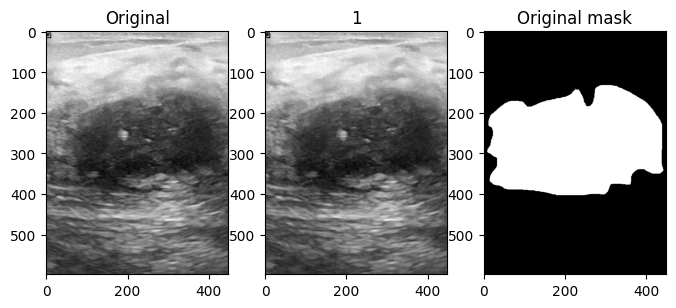

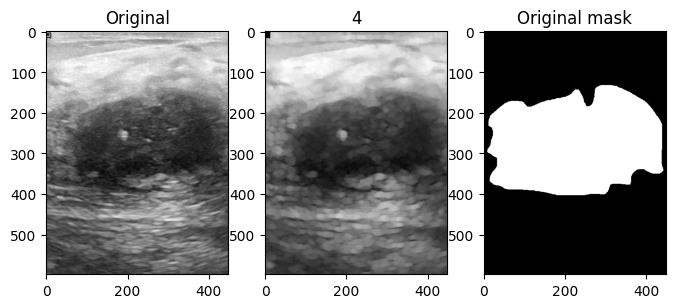

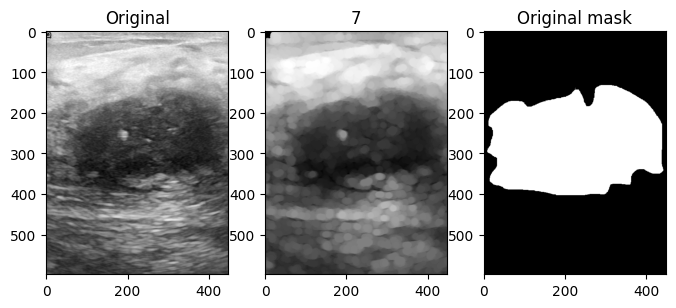

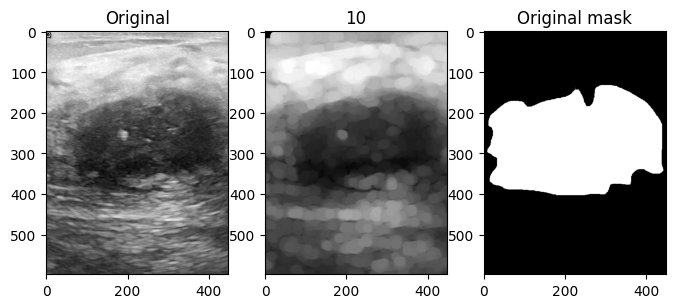

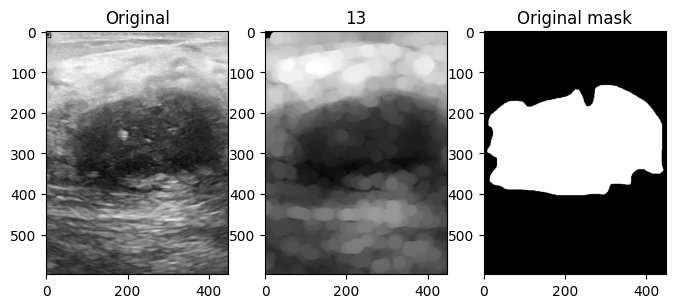

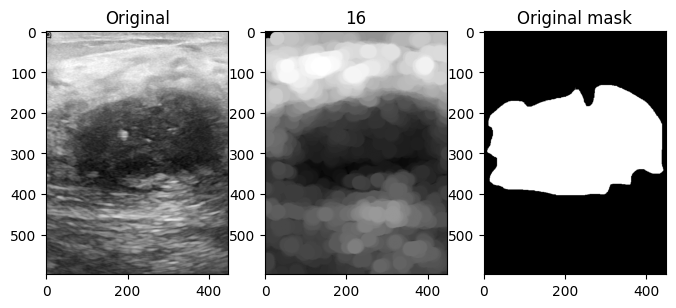

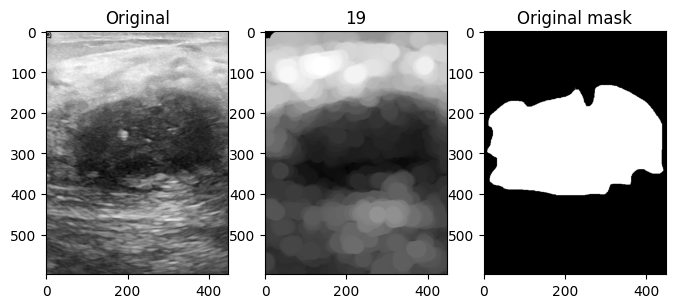

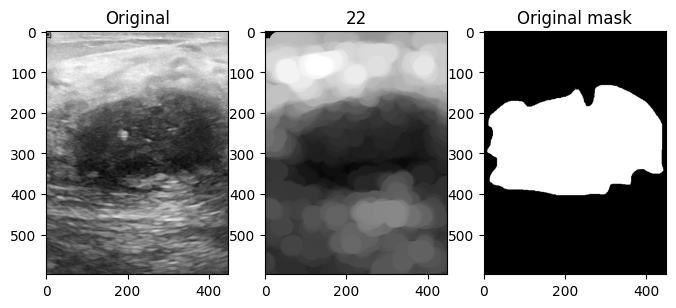

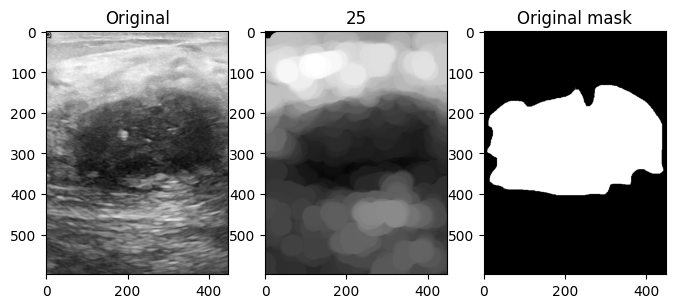

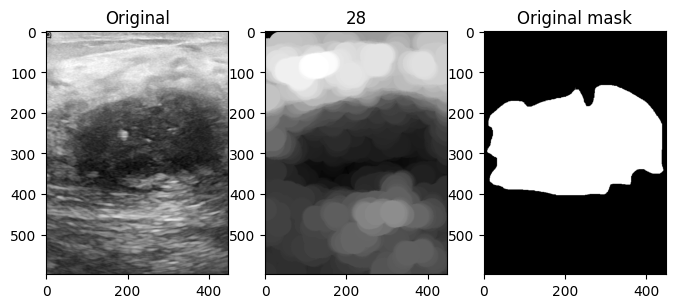

In [261]:
# Remove background using morphological opening
opening_range = range(1, 31, 3)
for _range in opening_range:

    img_open = morphology.opening(img, morphology.disk(_range))

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(img_open, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{_range}')
    axs[2].set_title('Original mask')
    plt.show()

In [262]:
img_open = morphology.opening(img, morphology.disk(19))

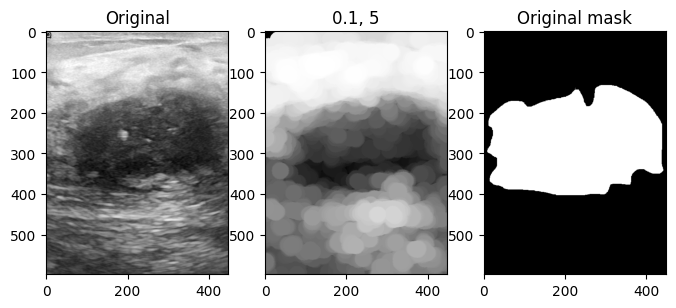

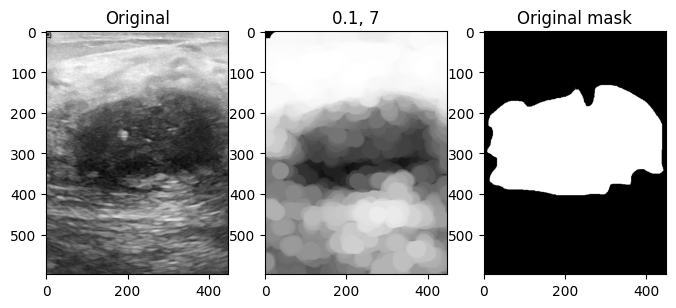

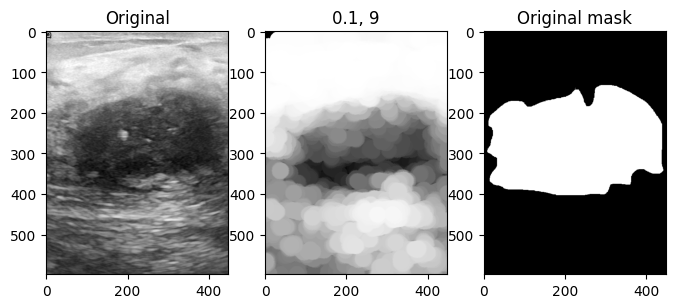

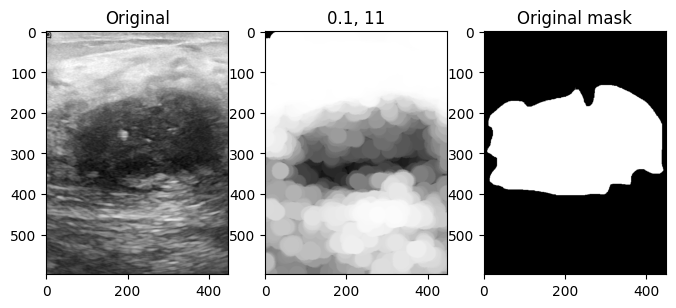

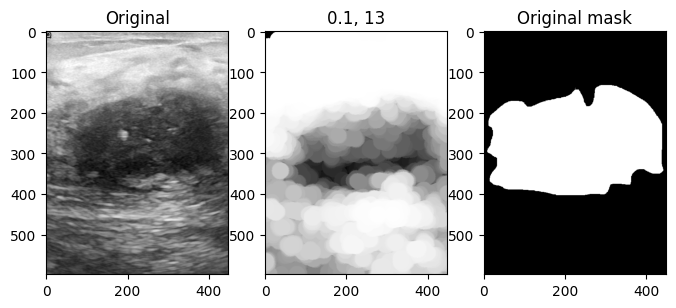

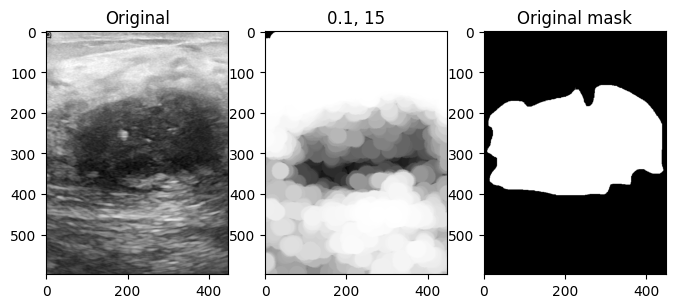

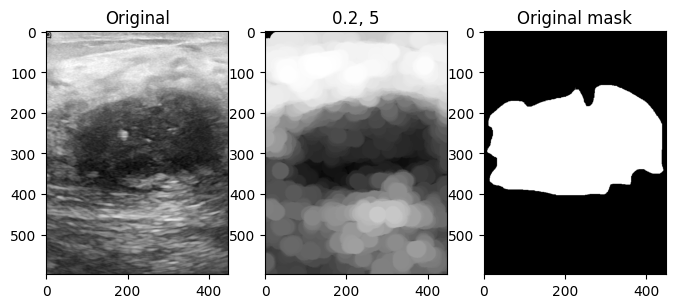

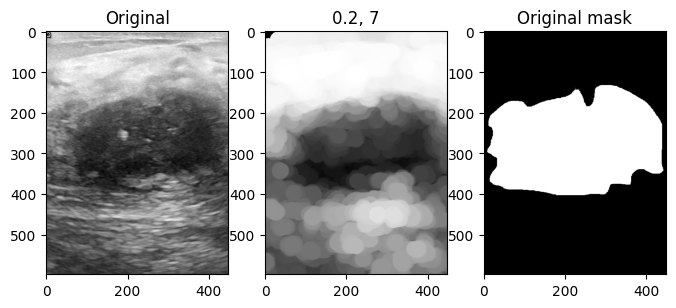

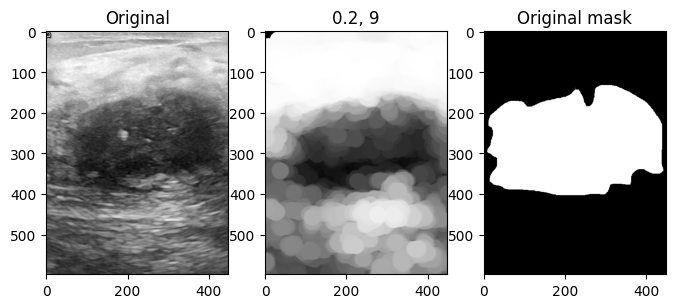

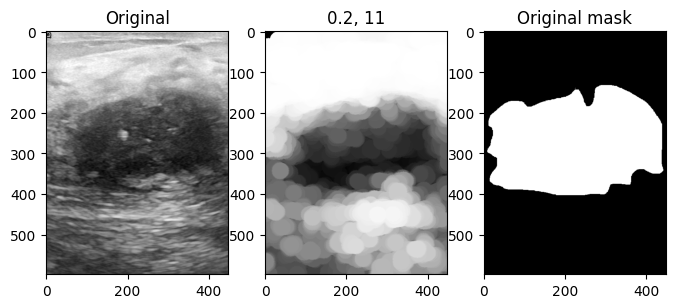

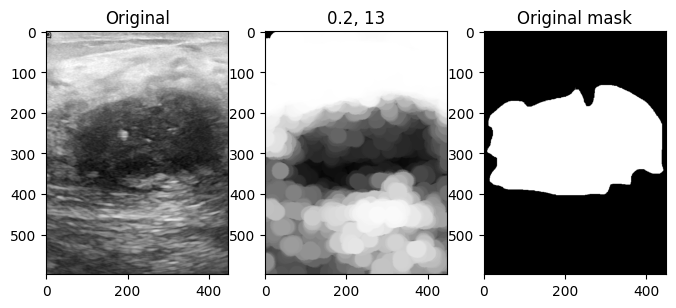

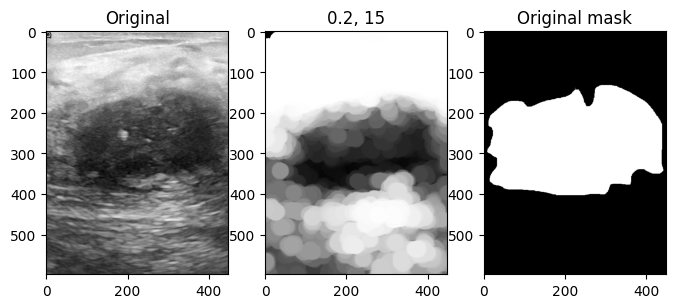

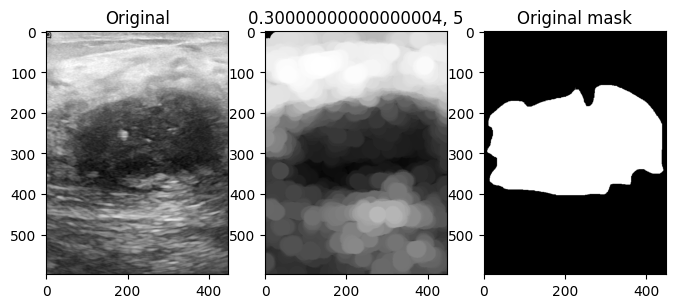

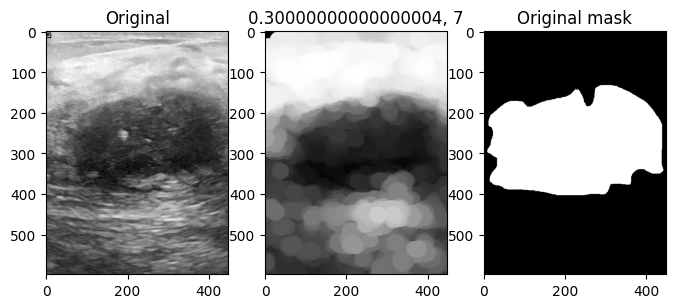

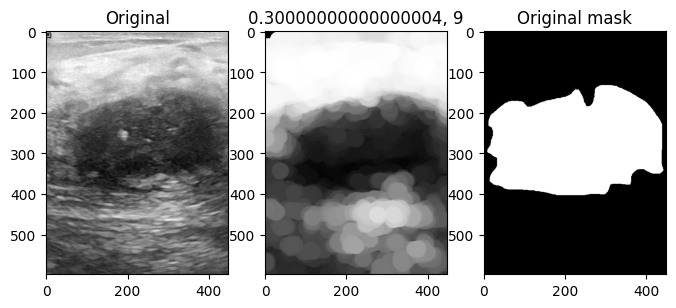

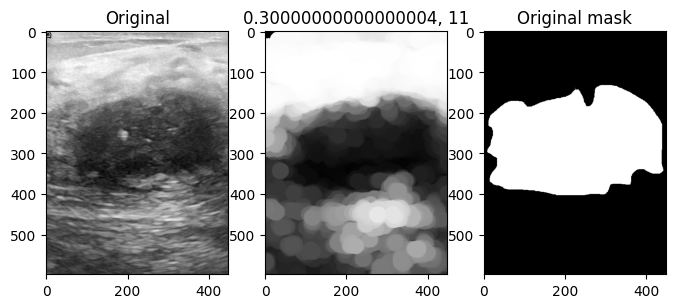

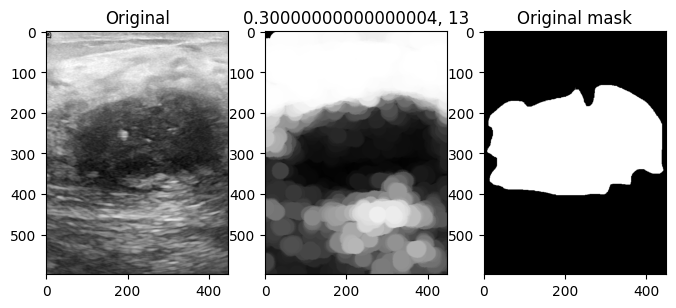

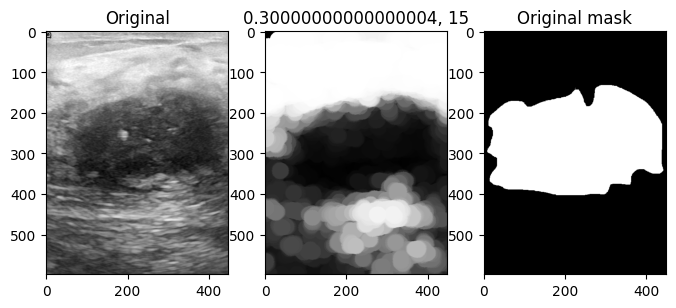

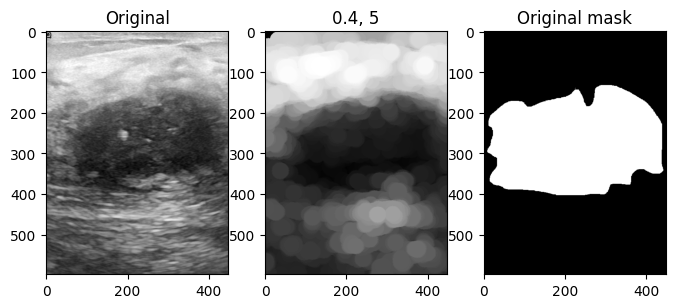

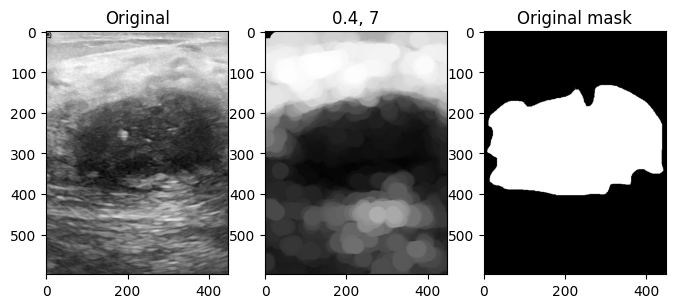

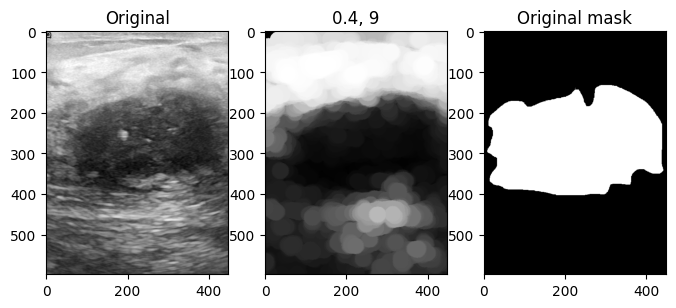

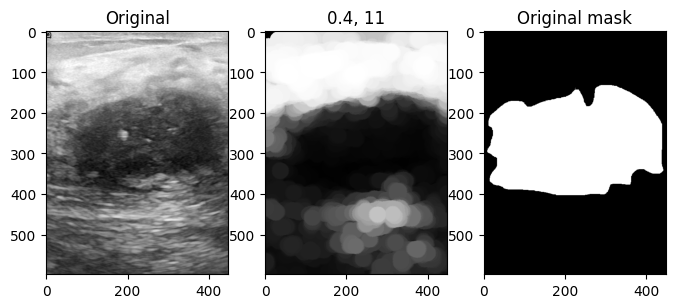

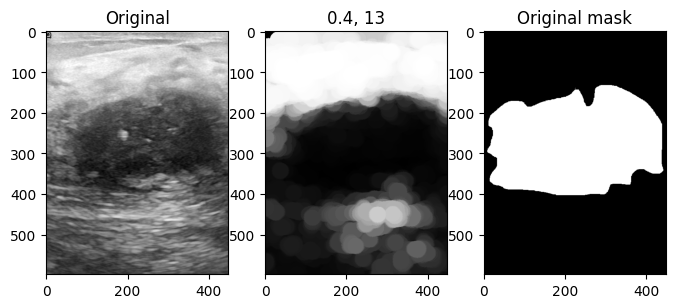

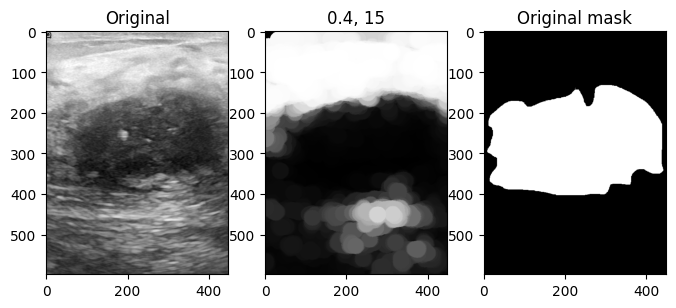

In [263]:
# Enhance contrast using sigmoid mapping
sigmoid_cutoff_range = np.linspace(0, 0.5, num=6)[1:-1]
sigmoid_gain_range = range(5, 16, 2)
for cutoff in sigmoid_cutoff_range:
    for gain in sigmoid_gain_range:

        img_sigmoid = exposure.adjust_sigmoid(img_open, cutoff=cutoff, gain=gain)

        # Display images using grayscale colormap
        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        axs[0].imshow(img, cmap='gray')
        axs[1].imshow(img_sigmoid, cmap='gray')
        axs[2].imshow(mask_org, cmap='gray')
        axs[0].set_title('Original')
        axs[1].set_title(f'{cutoff}, {gain}')
        axs[2].set_title('Original mask')
        plt.show()


In [264]:
img_sigmoid = exposure.adjust_sigmoid(img_open, cutoff=0.3, gain=13)

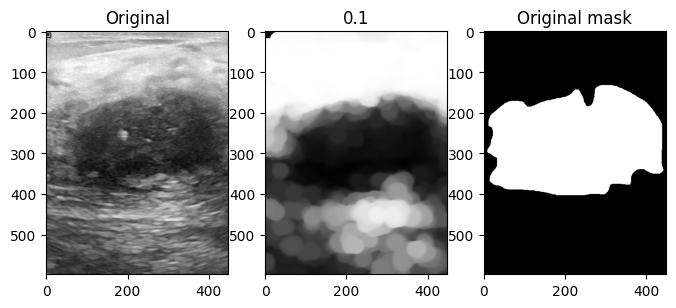

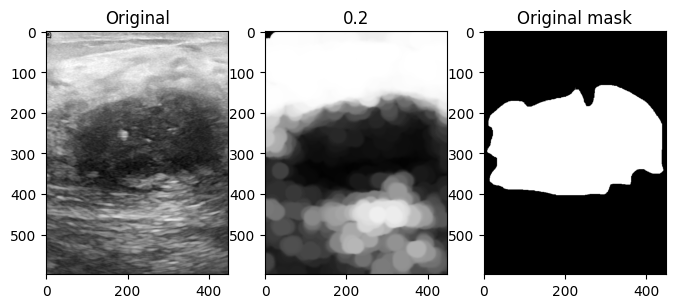

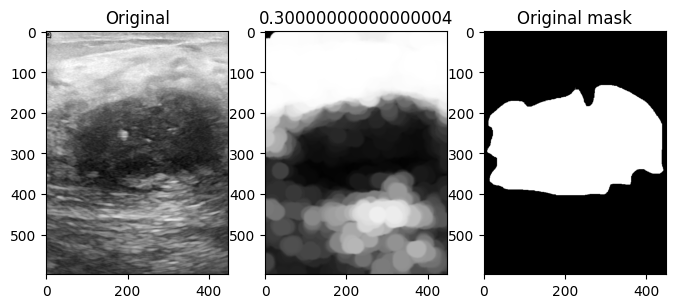

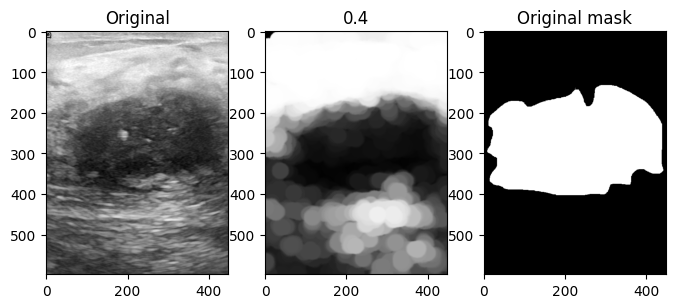

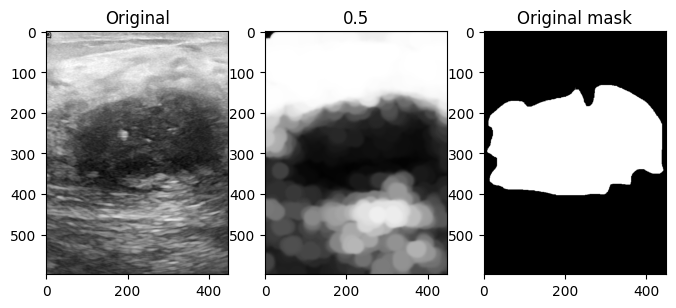

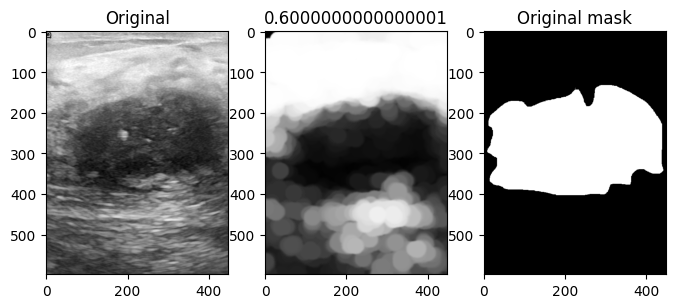

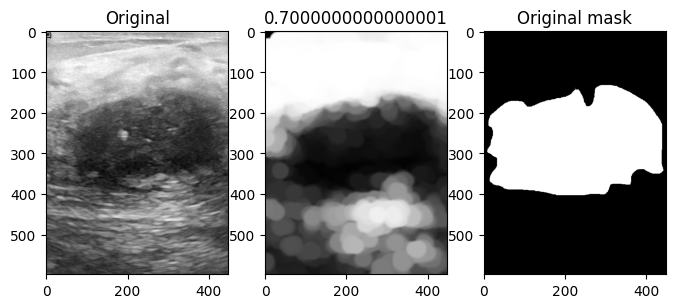

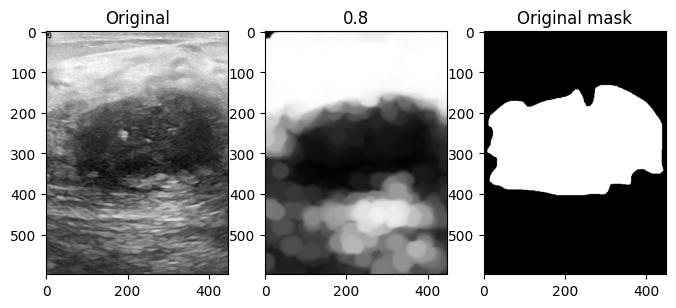

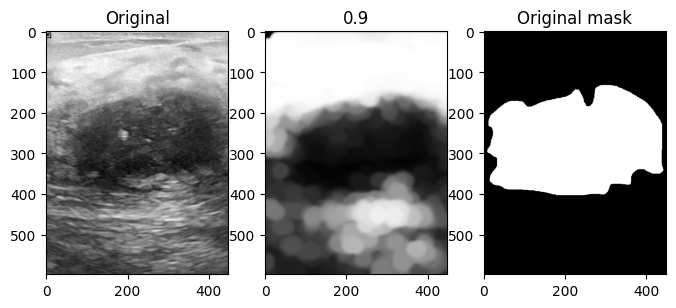

In [265]:
# Remove noise using total variation denoising
denoise_weight_range = np.linspace(0, 1, num=11)[1:-1]

for weight in denoise_weight_range:
    img_denoise = restoration.denoise_tv_chambolle(img_sigmoid, weight=weight)

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(img_denoise, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{weight}')
    axs[2].set_title('Original mask')
    plt.show()


In [266]:
img_denoise = restoration.denoise_tv_chambolle(img_sigmoid, weight=0.5)
# Normalize pixel values to [0,1]
img_norm = (img_denoise - np.min(img_denoise)) / (np.max(img_denoise) - np.min(img_denoise))

In [267]:
threshold

0.544921875

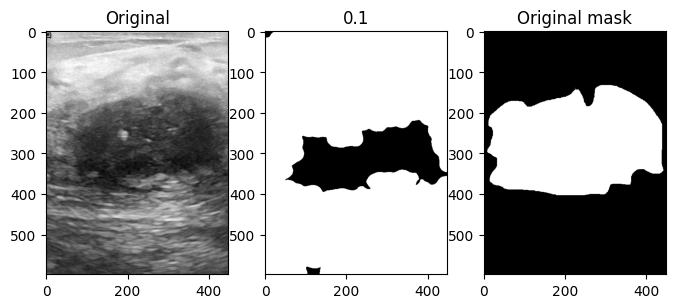

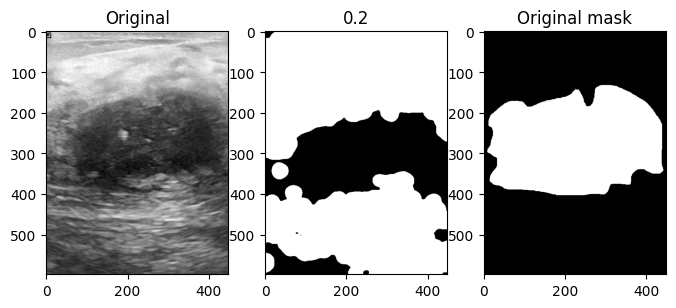

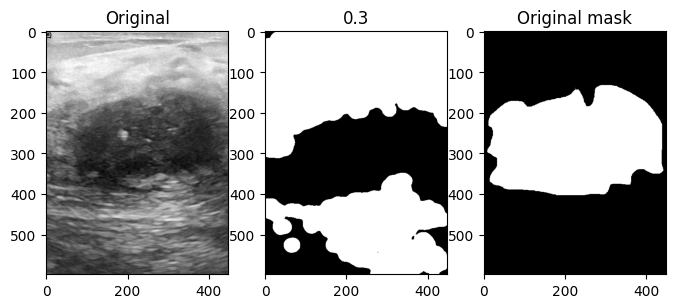

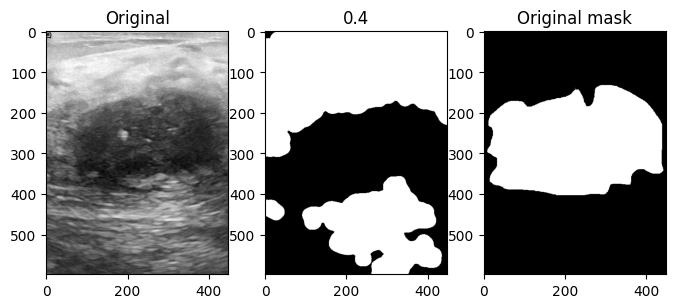

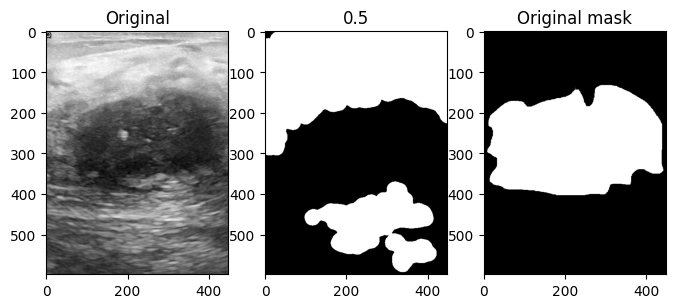

In [268]:
# Apply Otsu thresholding to segment lesion
threshold = filters.threshold_otsu(img_norm)
for t in range(1, 6):
    mask = img_norm > t/10

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(mask, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{t/10}')
    axs[2].set_title('Original mask')
    plt.show()

In [269]:
mask = img_norm > 0.2

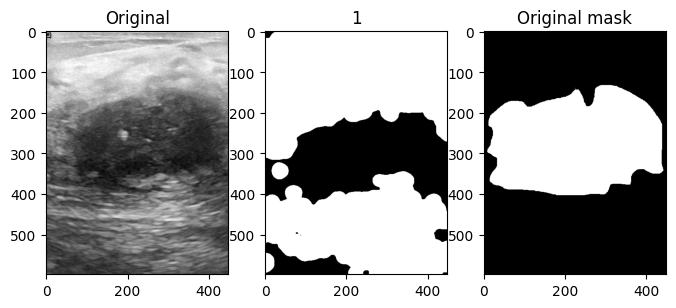

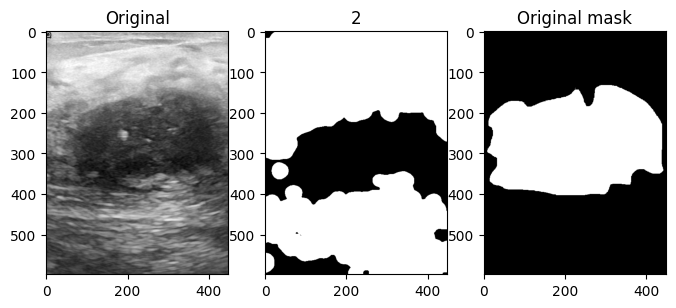

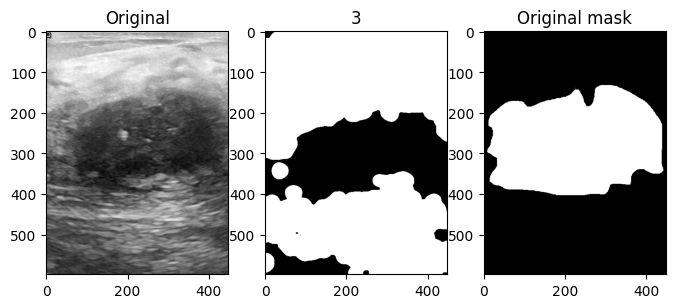

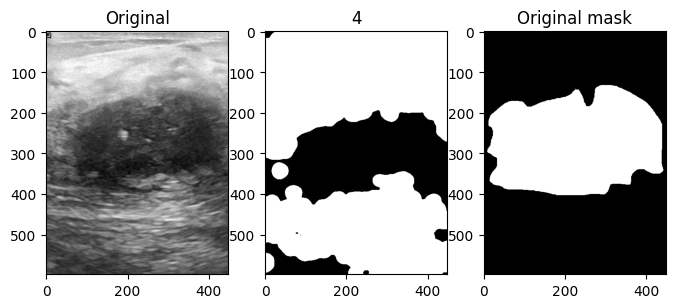

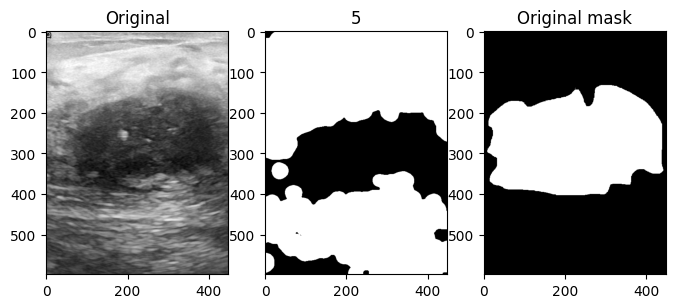

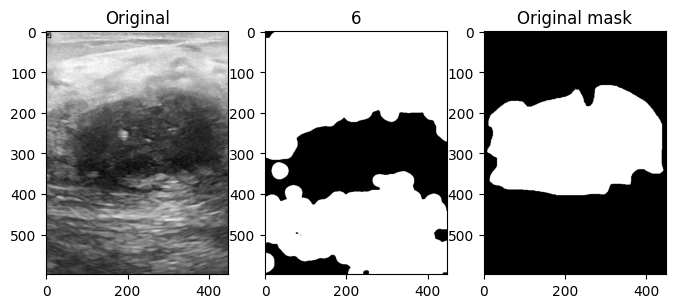

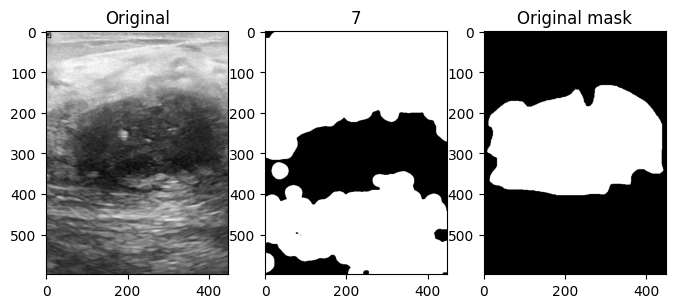

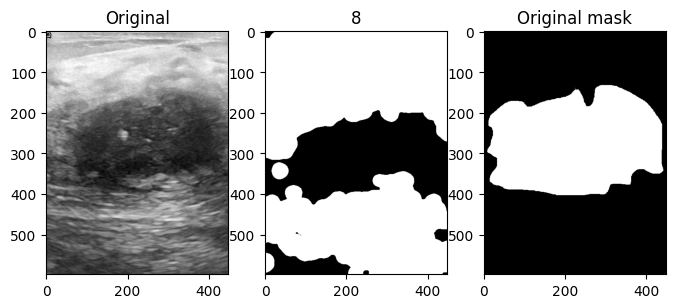

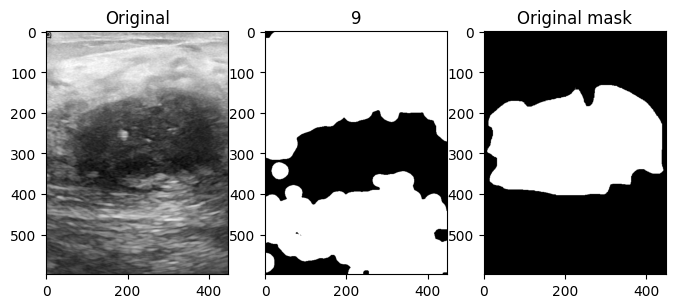

In [270]:
# Apply opening operation to remove small objects
for d in range(1, 10):
    mask_open = morphology.opening(mask, morphology.disk(d))
    
    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(mask_open, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{d}')
    axs[2].set_title('Original mask')
    plt.show()
    
# does not make a difference

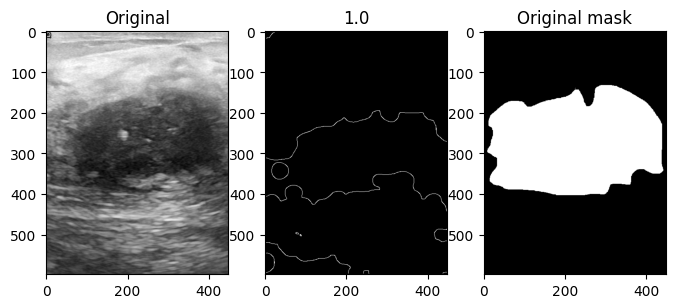

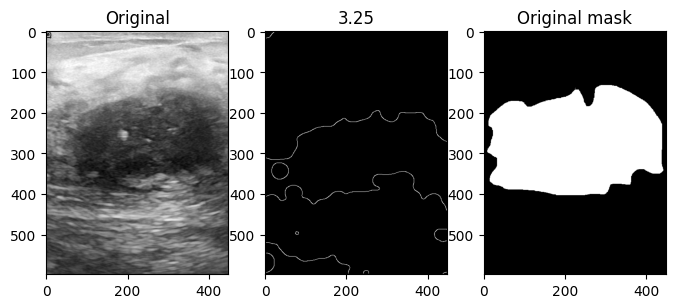

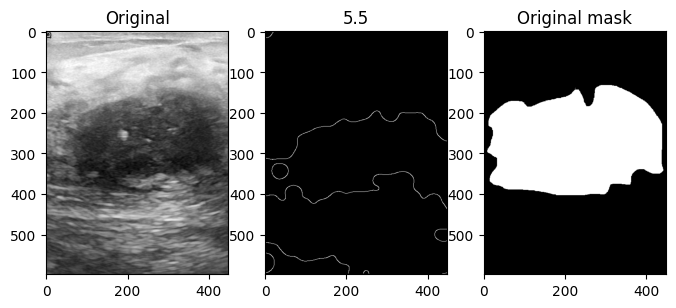

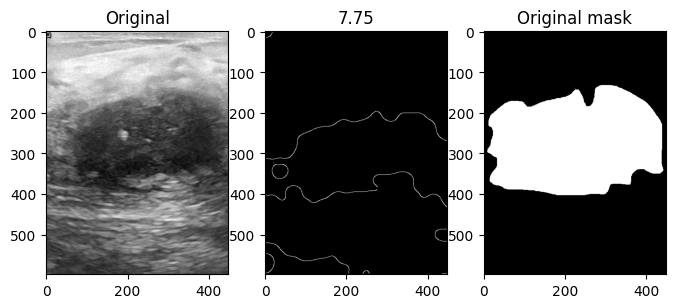

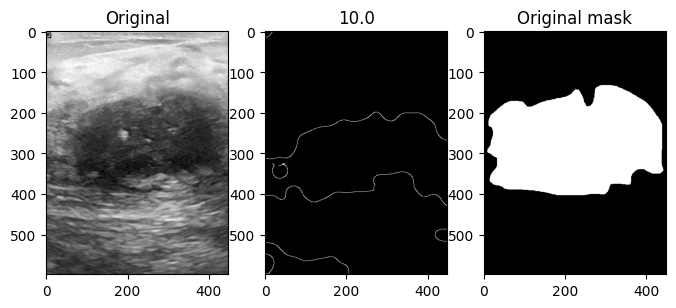

In [271]:
canny_sigma_range = np.linspace(1, 10, num=5)
for s in canny_sigma_range:
    edges = feature.canny(mask_open, sigma=s)

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(edges, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{s}')
    axs[2].set_title('Original mask')
    plt.show()

In [272]:
edges = feature.canny(mask, sigma=5.5)

C:\Users\z004m16m\AppData\Local\Temp\ipykernel_17116\1102039595.py:4: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = feature.peak_local_max(distance, indices=False, min_distance=int(sigma*2), threshold_rel=0.5, exclude_border=False)


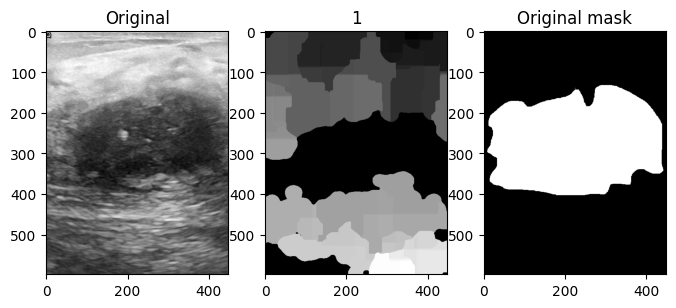

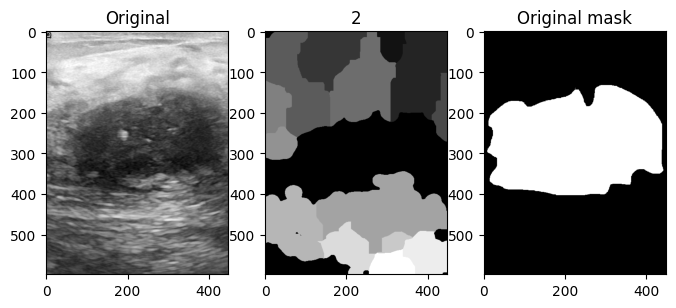

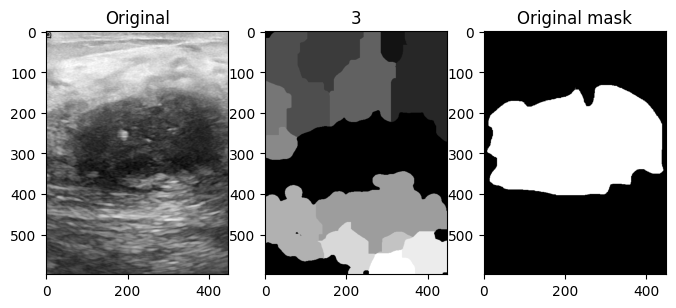

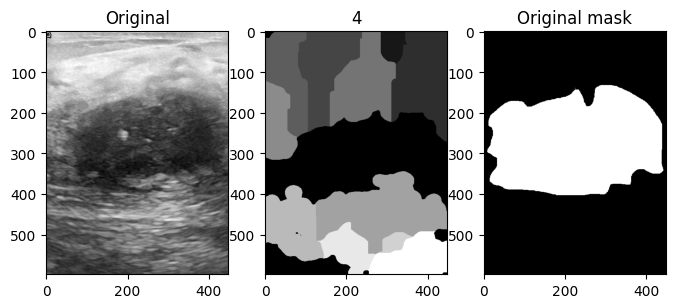

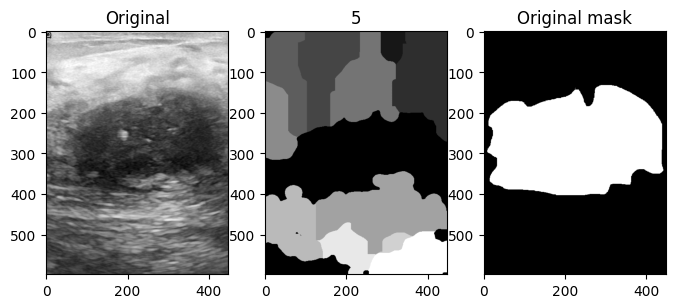

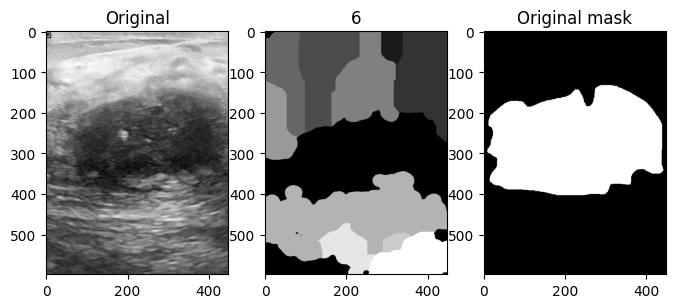

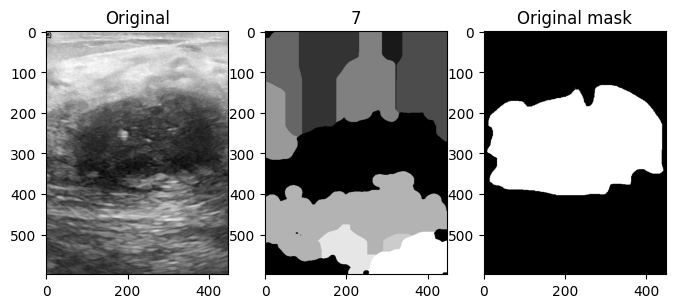

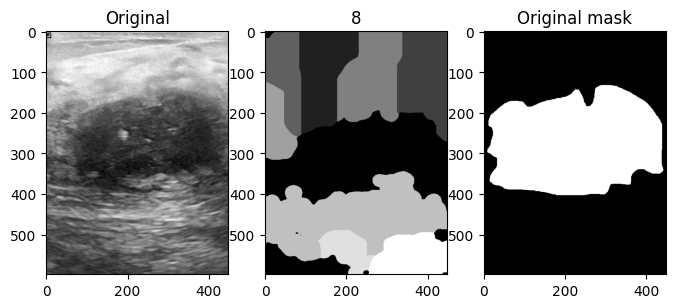

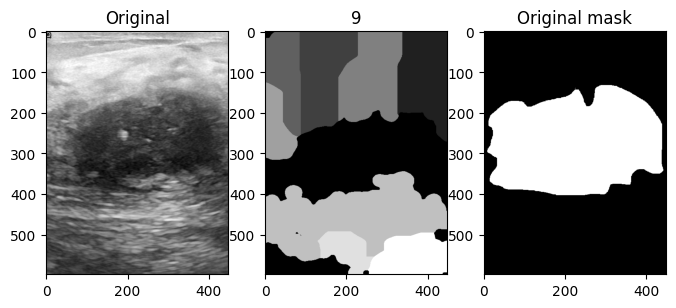

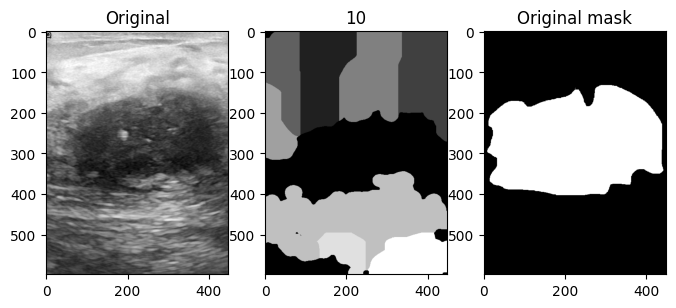

In [273]:
# Watershed segmentation
for sigma in range(1, 11):
    distance = filters.gaussian(img_norm, sigma=sigma)
    local_maxi = feature.peak_local_max(distance, indices=False, min_distance=int(sigma*2), threshold_rel=0.5, exclude_border=False)
    markers = measure.label(local_maxi)
    labels_ws = segmentation.watershed(-distance, markers, mask=mask)

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(labels_ws, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{sigma}')
    axs[2].set_title('Original mask')
    plt.show()

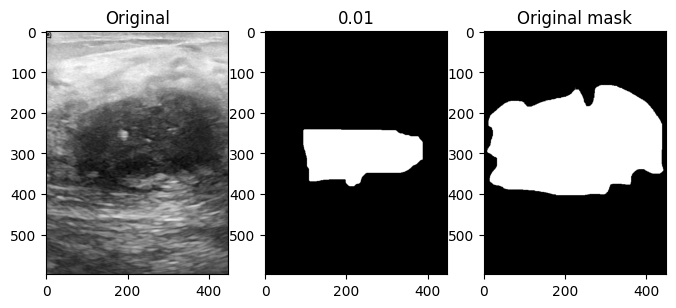

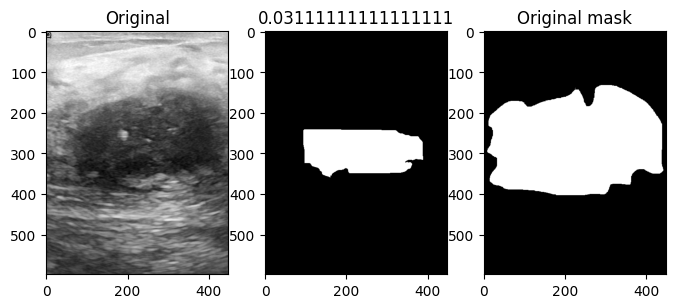

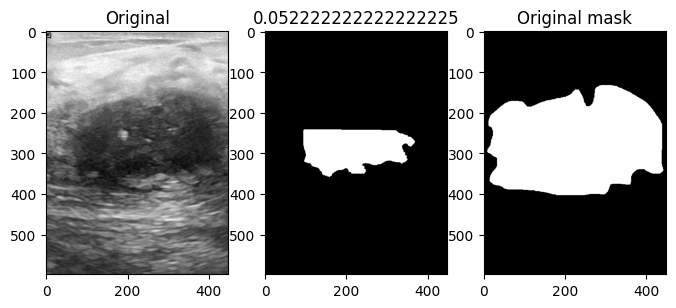

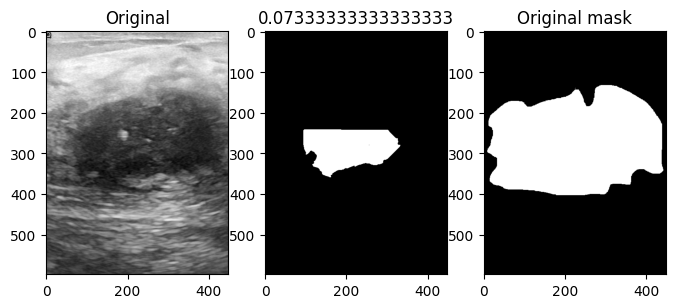

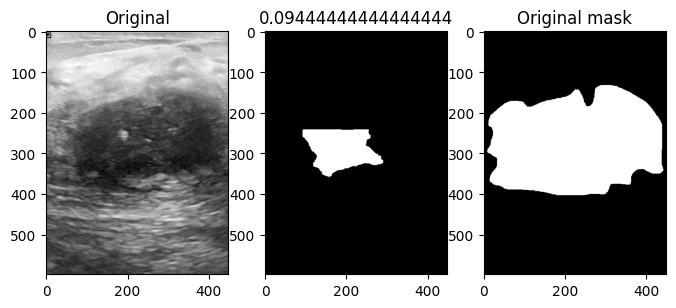

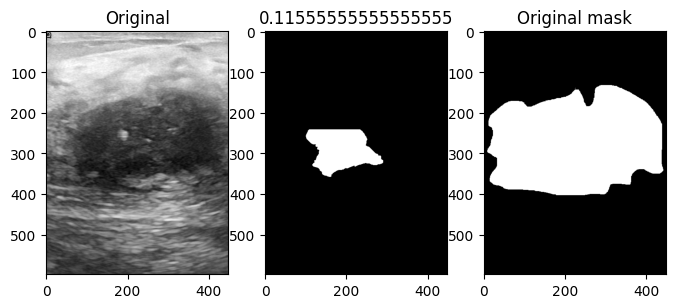

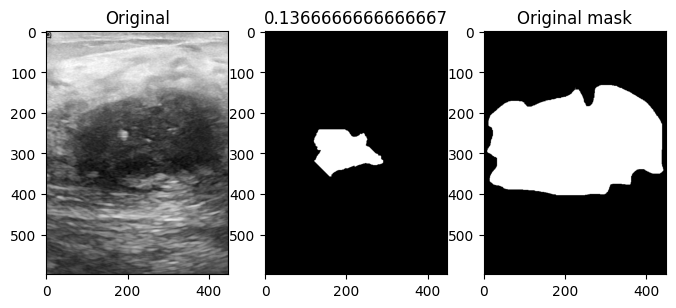

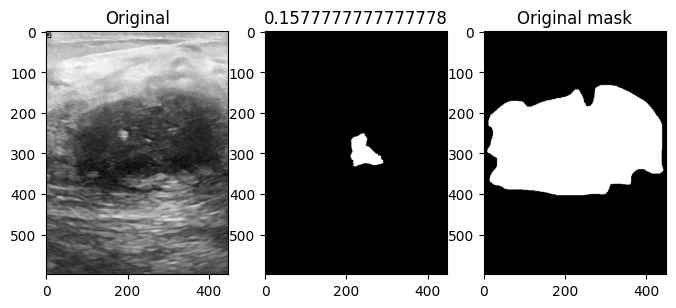

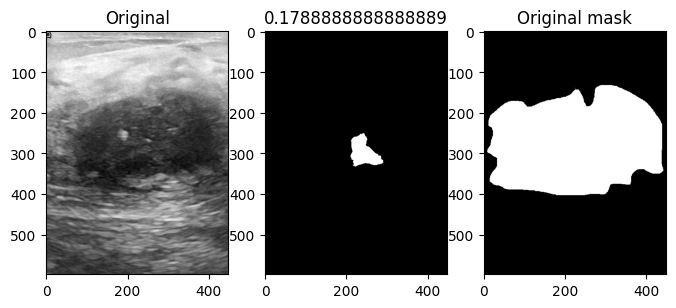

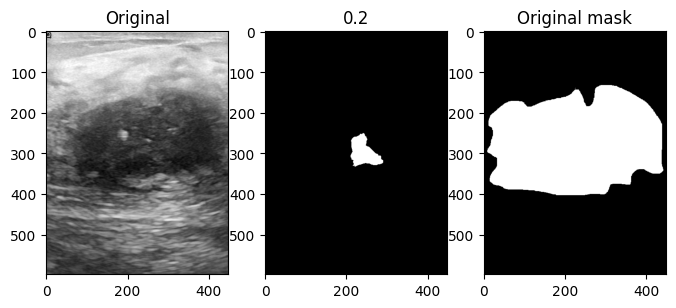

In [274]:
# Active contour segmentation
for contour_lambda in np.linspace(0.01, 0.2, num=10):
    init_contour = segmentation.disk_level_set(img_norm.shape, radius=50)
    labels_contour = segmentation.morphological_geodesic_active_contour(img_norm, num_iter=100, init_level_set=init_contour, smoothing=1, balloon=1, threshold=contour_lambda)

    # Display images using grayscale colormap
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(labels_contour, cmap='gray')
    axs[2].imshow(mask_org, cmap='gray')
    axs[0].set_title('Original')
    axs[1].set_title(f'{contour_lambda}')
    axs[2].set_title('Original mask')
    plt.show()

**Conclusion non-deep learning techniques**
Classic techniques can do a good job. Several parameters for pre-processing the image as well as for segmenting using canny, watershed, and active contours were tested on one image to get optimal results. Later, another image was tested to see if results are similar. In general, the techniques tended to remove too much of the lesion during segmentation. Additionally, trying to find the optimal parameters for generalization is very tedious. At first, a systematic approach was started, which would have taken several days to finish. Thus, this approach was abandoned and different parameters and their effects on the image were tested manually, as can be seen above.

In [25]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
# ----------------------- Fully Convolutional Network -----------------------
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from random import randint
from skimage.filters import threshold_otsu
from skimage.segmentation import active_contour
from sklearn.metrics import jaccard_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from typing import Tuple, Union, Dict

# define the FCN model
def create_fcn(input_shape=(256,256,1)):
    model = Sequential()
    
    # encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    return model

# ----------------------- Evaluation Functions -----------------------

# Define DICE loss function
def dice_loss(y_true, y_pred):
    # calculate the numerator of the DICE coefficient formula
    numerator = 2 * K.sum(y_true * y_pred, axis=(1, 2, 3))
    # calculate the denominator of the DICE coefficient formula
    denominator = K.sum(y_true + y_pred, axis=(1, 2, 3))
    # calculate the DICE loss
    return 1 - K.mean(numerator / denominator)

# Define JACCARD loss function
def jaccard_loss(y_true, y_pred):
    # calculate the intersection of the true and predicted masks
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    # calculate the union of the true and predicted masks
    union = K.sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    # calculate the JACCARD loss
    return 1 - K.mean(intersection / union)

# Define combined loss function
def dice_jaccard_loss(y_true, y_pred):
    # calculate the sum of DICE and JACCARD losses
    return dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)

# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    # flatten the true and predicted masks
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # calculate the DICE and JACCARD measures
    dice = (2.0 * np.sum(y_true * y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    jaccard = np.sum(y_true * y_pred) / (np.sum(y_true) + np.sum(y_pred) - np.sum(y_true * y_pred))

    return dice, jaccard

# ----------------------- Functions to load data -----------------------

# function to overlay multiple masks
def overlay_masks(mask_name: str, data_dir: str, img_shape: tuple) -> np.ndarray:
    """
    Overlays binary masks into one image and returns the overlay binary mask.
    Args:
    - mask_name: A string representing the name of the binary masks.
    - data_dir: A string representing the directory where the binary masks are stored.
    - img_shape: A tuple representing the shape of the final image (height, width, channels).

    Returns:
    - overlay_binary: A numpy array representing the binary mask of the overlay image.
    """
    # load all the binary masks and overlay them into one image
    mask_filenames = [filename for filename in os.listdir(data_dir) if mask_name in filename]

    if len(mask_filenames) > 1:
        overlay = np.zeros(img_shape[:2])
        for mask_filename in mask_filenames:
            mask_path = os.path.join(data_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert('L').resize(img_shape[:2])) / 255.0
            overlay += mask

        # threshold the overlay image
        thresh = 0.5
        overlay_binary = (overlay > thresh).astype(np.uint8)

        # save the overlay image
        overlay_image = Image.fromarray(overlay_binary * 255)
        overlay_mask_path = os.path.join(data_dir, mask_name + "_overlay.png")
        # check if file already exists
        if os.path.isdir(overlay_mask_path):
            overlay_image.save(os.path.join(data_dir, mask_name + "_overlay.png"))

        return overlay_binary
    else:
        # If there is only one binary mask, return it directly
        mask_path = os.path.join(data_dir, mask_filenames[0])
        mask = np.array(Image.open(mask_path).convert('L').resize(img_shape[:2])) / 255.0
        
        return mask

# function to load and preprocess the dataset
def load_data(split_classes: bool = False, repeat: bool = False) -> Union[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]]:
    """
    Load images and masks from the dataset directory and split them into training and validation sets.

    Args:
        split_classes (bool): If True, return separate dictionaries for each tumor type with their corresponding images and masks.
        repeat (bool): If True, return repeated grayscale images with 3 channels.

    Returns:
        If split_classes is False, return a tuple of X_train, X_val, y_train, and y_val arrays.
        If split_classes is True, return a tuple of image and mask dictionaries for each tumor type.
    """
    images = []
    masks = []
    
    if split_classes:
        image_dict = {}
        mask_dict = {}

    # Loop through each subdirectory in the dataset directory
    for tumor_type in os.listdir(data_dir):
        tumor_type_dir = os.path.join(data_dir, tumor_type)
        # Loop through each image file in the tumor type subdirectory
        for filename in os.listdir(tumor_type_dir):
            # Check if the file is an image file in PNG format
            if filename.endswith('.png'):
                # Check if the file is a mask image or not
                if ("mask" not in filename) & ("pred" not in filename) & ("overlay" not in filename):
                    # Save image and mask directory (only first mask considered)
                    img_path = os.path.join(tumor_type_dir, filename)
                    # Open the image and mask files, convert to grayscale, and resize to the specified dimensions
                    img = Image.open(img_path).convert('L').resize((img_width, img_height))
                    # normalize the image and mask pixel values to [0, 1]
                    img = np.array(img) / 255.0
                    
                    mask_filename = filename.split(".png")[0] + "_mask"
                    # Get overlayed masks
                    mask = overlay_masks(mask_filename, tumor_type_dir, img.shape)
                    
                    # Append the image and mask arrays to their respective lists
                    images.append(img)
                    masks.append(mask)
                    
        if split_classes:
            image_dict[tumor_type] = np.array(images)
            mask_dict[tumor_type] = np.array(masks)
    
    if split_classes:
        return image_dict, mask_dict
    
    if repeat:
        images = np.array([preprocess_input(np.repeat(image[..., np.newaxis], 3, axis=-1)) for image in images])
        masks = np.array([np.repeat(mask[..., np.newaxis], 3, axis=-1) for mask in masks])

    else:
        # convert the images and masks to numpy arrays
        images = np.array(images)
        masks = np.array(masks)

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val

# function to calcualte OTSU threshold and apply active contours
def thresh_snake(predicted_mask: np.ndarray) -> np.ndarray:
    """
    Applies Otsu threshold and active contours on a predicted mask of image segmentation.

    Args:
        predicted_mask: A NumPy array representing the predicted mask for image segmentation.

    Returns:
        A NumPy array representing the mask created using the active contours.
    """
    # threshold the predicted mask
    thresh = threshold_otsu(predicted_mask)
    predicted_mask_binary = (predicted_mask > thresh).astype(np.uint8)

    # apply active contours
    snake = active_contour(predicted_mask, predicted_mask_binary, alpha=0.1, beta=1.0, w_line=-1, w_edge=1, gamma=0.1, max_num_iter=2500, convergence=0.1)

    # create a mask using the contours
    rr, cc = np.round(snake[:, 0]).astype(int), np.round(snake[:, 1]).astype(int)
    predicted_mask_binary[rr, cc] = 1

    return predicted_mask_binary

######################################################################################################

In [7]:
# ----------------------- Create Model -----------------------
# compile the model
model = create_fcn()
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_jaccard_loss, metrics=[dice_loss, jaccard_loss])
# the model performed way better with the following loss function:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ----------------------- Load data -----------------------
# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'
img_height, img_width = 256, 256

# load the dataset
X_train, X_val, y_train, y_val = load_data()

# data augmentation for the training set
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

# data augmentation for the validation set
val_datagen = ImageDataGenerator()

# ----------------------- Train Model -----------------------

# define the batch size and number of epochs
batch_size = 16
epochs = 50

# define the model checkpoint to save the best model weights
checkpoint = ModelCheckpoint('fcn_best_weights_overlayed_masks.h5', save_best_only=True, save_weights_only=True, mode='min', verbose=1)

# train the model
history = model.fit(train_datagen.flow(np.expand_dims(X_train, axis=-1), np.expand_dims(y_train, axis=-1), batch_size=batch_size),
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=epochs,
                              validation_data=val_datagen.flow(np.expand_dims(X_val, axis=-1), np.expand_dims(y_val, axis=-1), batch_size=batch_size),
                              validation_steps=len(X_val) // batch_size,
                              callbacks=[checkpoint])

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.9184
Epoch 1: val_loss improved from inf to 0.25695, saving model to fcn_best_weights_overlayed_masks.h5
39/39 [==============================] - 123s 3s/step - loss: 0.3543 - accuracy: 0.9184 - val_loss: 0.2569 - val_accuracy: 0.9242
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9189
Epoch 2: val_loss improved from 0.25695 to 0.24731, saving model to fcn_best_weights_overlayed_masks.h5
39/39 [==============================] - 132s 3s/step - loss: 0.2722 - accuracy: 0.9189 - val_loss: 0.2473 - val_accuracy: 0.9218
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9189
Epoch 3: val_loss improved from 0.24731 to 0.24581, saving model to fcn_best_weights_overlayed_masks.h5
39/39 [==============================] - 134s 3s/step - loss: 0.2505 - accuracy: 0.9189 - val_loss: 0.2458 - val_accuracy: 0.9202
Epoch 4/50
39/39 [==

1/1 [==============================] - 0s 72ms/step
DICE score:  0.8385290646562699
JACCARD score:  0.7219544106870934


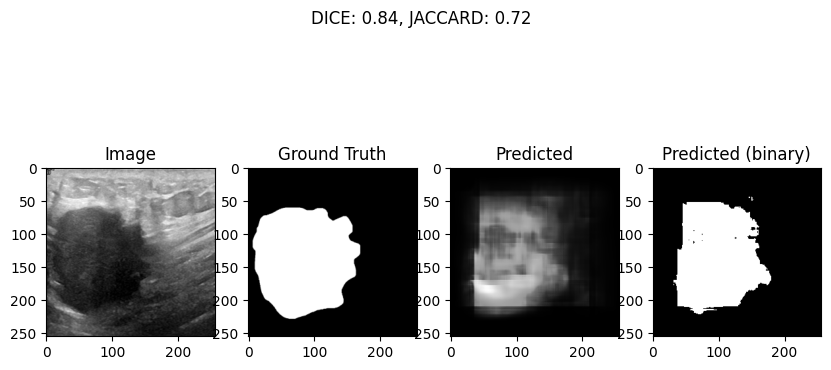

In [28]:
# ----------------------- Test Model Predictions -----------------------
# Load weights
model.load_weights('fcn_best_weights_overlayed_masks.h5')
# model.load_weights('binary_cross_entropy_and_accuracy_fcn_best_weights.h5')
ind = randint(1, 210) # random image

# test the model on a sample image
sample_img_dir = data_dir + f'\\malignant\\malignant ({ind}).png'
test_img = Image.open(sample_img_dir).convert('L').resize((img_width, img_height))
test_img = np.array(test_img) / 255.0
test_img = np.expand_dims(test_img, axis=0)
initial_mask = np.squeeze(model.predict(test_img)[0])

ground_truth_dir = data_dir + f'\\malignant\\malignant ({ind})_mask.png'
ground_truth = Image.open(ground_truth_dir).convert('L').resize((img_width, img_height))
ground_truth = np.array(ground_truth) / 255.0
ground_truth = np.expand_dims(ground_truth, axis=0)

initial_mask_binary = thresh_snake(initial_mask)

# evaluate the model
dice, jaccard = evaluate_model(ground_truth, initial_mask_binary)
print("DICE score: ", dice)
print("JACCARD score: ", jaccard)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(test_img.reshape(256, 256), cmap='gray')
axs[0].set_title('Image')
axs[1].imshow(ground_truth.reshape(256, 256), cmap='gray')
axs[1].set_title('Ground Truth')
axs[2].imshow(initial_mask.reshape(256, 256), cmap='gray')
axs[2].set_title('Predicted')
axs[3].imshow(initial_mask_binary.reshape(256, 256), cmap='gray')
axs[3].set_title('Predicted (binary)')

# add the average DICE and JACCARD scores to the plot title
fig.suptitle(f'DICE: {dice:.2f}, JACCARD: {jaccard:.2f}')

# show the plot
plt.show()

In [34]:
# ----------------------- Avg. DICE & Jaccard over all validaiton images -----------------------
# Load split data
image_dict, mask_dict = load_data(split_classes=True)

# test the model on the validation set and calculate the average DICE and JACCARD measures
dice_scores = []
jaccard_scores = []
classes = ["benign", "malignant", "normal"]
for c in classes:
    print(f'Class: {c}')
    for i in tqdm(range(len(image_dict[c]))):
        pred_mask = np.squeeze(model.predict(np.expand_dims(image_dict[c][i], axis=0), verbose=0)[0])
        # threshold predicted mask & apply active contours
        pred_mask = thresh_snake(pred_mask)
        # evaluate predictions
        dice, jaccard = evaluate_model(mask_dict[c][i], pred_mask)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)

    print(f'Average DICE score class {c}:', avg_dice)
    print(f'Average JACCARD score class {c}:', avg_jaccard)

Class: benign


100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [01:34<00:00,  4.65it/s]


Average DICE score class benign: 0.3697479242114612
Average JACCARD score class benign: 0.2705365297330615
Class: malignant


100%|████████████████████████████████████████████████████████████████████████████████| 647/647 [02:21<00:00,  4.58it/s]


Average DICE score class malignant: 0.4064819771786754
Average JACCARD score class malignant: 0.29895011928294357
Class: normal


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [03:24<00:00,  3.82it/s]

Average DICE score class normal: 0.38609071010888396
Average JACCARD score class normal: 0.28428079136913836


**b.** Create a report of your segmentation efforts.
Try answering the following questions:

**Which methods did you try? Can you reason your choices?**

Classic methods:
- Preprocessing steps: morphology opening, sigmoid adjustment, denoising, normalization
- Edge detection: canny, active contours, level sets (not in code as it yielded practically useless results)

Neural Networks:
- Fully Convolutional Network (FCN): built the architecture from scratch, trained on images in given data set.
- VGG16 + U-Net: Used transfer learning to get pre-trained VGG16 model and enhanced it with the U-Net architecture.

Neural networks have several advantages over classic, non-deep learning methods for image segmentation tasks, including:
- Ability to learn complex features: FCN networks can automatically learn complex features from images, which is particularly useful for segmentation tasks where traditional methods rely on hand-engineered features.
- End-to-end learning: FCN networks are trained end-to-end, meaning that the entire model is optimized to minimize the segmentation error, rather than separate optimization of different steps in a pipeline. This can lead to better overall performance.
- Flexibility: FCN networks can be applied to a variety of image segmentation tasks and can be easily modified to accommodate different input image sizes and output resolutions.
- Scalability: FCN networks can be trained on large datasets with high variability in the input data, enabling the model to generalize better to new, unseen data.

**Which method worked the best for you? Which method worked the worst? Can you think why?**
Best worked the FCN. This indeed surprised us as we expected the VGG16 + U-Net approach to outperform the rest. But there were several issues with the approach which lead to us having a hard time implementing it. Once the training process finished without any errors we had to find out that the predictions were pure garbage. As of now we did not look any further into it, but it might well be that there must be some mistake in the preprocessing of the data.

**How well did your methods work per class (benign, malignant, and normal)?**

Class: benign

Average DICE score class benign: 0.3697479242114612

Average JACCARD score class benign: 0.2705365297330615

Class: malignant

Average DICE score class malignant: 0.4064819771786754

Average JACCARD score class malignant: 0.29895011928294357

Class: normal

Average DICE score class normal: 0.38609071010888396

Average JACCARD score class normal: 0.28428079136913836


**Answer:** See cell above

## Problem 2: Geometric Features (21 points)

As you may know, the geometric features of a tumor can sometimes reveal significant information about whether it is *benign* or *malignant*. [Radiologists frequently assess the geometry of lesions in mammograms when attempting to diagnose breast cancer](https://www.sciencedirect.com/science/article/pii/S2211568413003872).

In this exercise, we will attempt to explore some quantitative methods of differentiating between certain lesion shapes.

Download the two mammograms from Teams: `LEFT_CC_BENIGN.tif` depicts a cranial-caudal view (looking down on the breast from the patient's perspective) of the left breast. There is a benign lesion present in the mammogram. Can you locate it? 

If you are having difficulty locating the lesion, try seeing if you can spot it in the mask `LEFT_CC_BENIGN_MASK.tif`, which consists of a rough segmentation of the lesion. `RIGHT_CC_MALIGNANT.tif` and `RIGHT_CC_MALIGNANT_MASK.tif` are the mammogram and corresponding lesion segmentation of a different patient, but this mammogram depicts a breast with a **malignant** tumor.

**a.** Start by loading these two mammograms and their corresponding masks as image matrices. 
Plot them on a single figure (e.g., using a 2-by-2 grid of subplots). You should use reasonable **x** and **y** limits in your figures to get a reasonable depiction of your lesion segmentations.

Qualitatively describe the shape differences between the two lesions. What types of shapes and margins are indicative of malignant tumors?

**Answer:**

- The malignant tumor is irregularly shaped, with spiky edges that are not smooth.
- The spiky margins extend outwards from the main body of the tumor.
- The malignant tumors appears as high-density area on the mammogram, indicating that it is denser than the surrounding tissue.

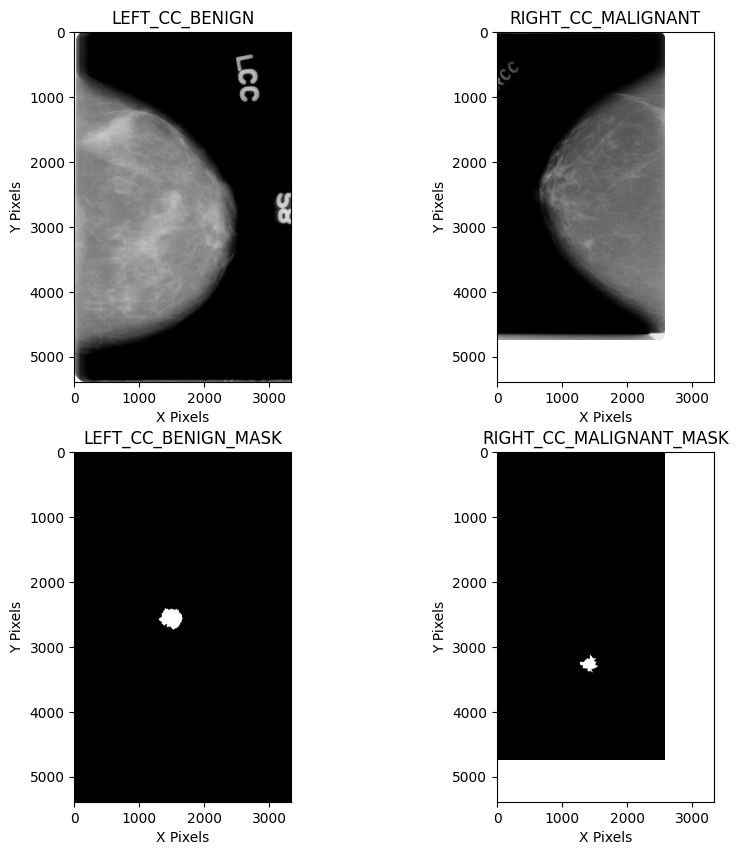

In [35]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_mammograms(mammogram_path: str, mammogram2_path: str, mask_path: str, mask2_path: str,
                    figsize: tuple = (10, 10), titles: list = ['Mammogram 1', 'Mammogram 2', 'Mask 1', 'Mask 2']) -> None:
    """
    Load mammogram images and their corresponding masks as numpy arrays, and plot them on a 2x2 grid of subplots.
    
    Parameters:
    mammogram_path (str): File path of the first mammogram image (.tif).
    mammogram2_path (str): File path of the second mammogram image (.tif).
    mask_path (str): File path of the mask for the first mammogram image (.tif).
    mask2_path (str): File path of the mask for the second mammogram image (.tif).
    figsize (tuple, optional): Size of the plot figure in inches. Default is (10, 10).
    titles (list, optional): List of titles to assign to each plot.
    """
    # Load the mammogram images and masks as numpy arrays
    mammogram = np.array(Image.open(mammogram_path))
    mammogram2 = np.array(Image.open(mammogram2_path))
    mask = np.array(Image.open(mask_path))
    mask2 = np.array(Image.open(mask2_path))

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # Plot the mammogram images in the top row
    axs[0, 0].imshow(mammogram, cmap='gray')
    axs[0, 0].set_title(titles[0])
    axs[0, 1].imshow(mammogram2, cmap='gray')
    axs[0, 1].set_title(titles[1])

    # Plot the mask images in the bottom row
    axs[1, 0].imshow(mask, cmap='gray')
    axs[1, 0].set_title(titles[2])
    axs[1, 1].imshow(mask2, cmap='gray')
    axs[1, 1].set_title(titles[3])

    # Set reasonable x and y limits for the subplots
    for ax in axs.flat:
        ax.set(xlabel='X Pixels', ylabel='Y Pixels', xlim=[0, mammogram.shape[1]], ylim=[mammogram.shape[0], 0])

    # Display the figure
    plt.show()
    
mammogram_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
mask_path = 'data/LEFT_CC_BENIGN_MASK.tif'
mask2_path = 'data/RIGHT_CC_MALIGNANT_MASK.tif'

plot_mammograms(
    mammogram_path, 
    mammogram2_path, 
    mask_path, 
    mask2_path, 
    figsize = (10, 10),
    titles = [x.split("/")[1].split(".")[0] for x in [mammogram_path, mammogram2_path, mask_path, mask2_path]])

######################################################################################################


**b.** Next, try computing some basic geometric features of the two lesions. Which features are the most significant for differentiating between them? Is this what you expected? The `regionprops()` function in the `skimage` library will automatically compute several geometric features for you, but you might choose to code up some of your own. If you don't trust the provided segmentations, feel free to create your segmentation method or modify the provided ones to get a better estimate of the lesion shapes! Finally, it could be interesting to apply some edge-detection filters to the mammograms to better emphasize the margins. 

You can also test your approach on other mammograms from a [larger dataset (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH). 

**There is no single correct answer for this exercise, and you should definitely try several different approaches and explore!**

**Answer**:

Malignant vs. benign tumor - important features:
- Solidity 20% lower
- Haralick contrast 34% lower
- the response of the Gabor filters was stronger and more localized in the malignant tumor compared to the benign tumor. This could indicate that the malignant tumor has a more complex and irregular texture, which is a characteristic of cancerous growth.
- Wavelet features all show high differences as well. The results suggest that the malignant tumor has more high-frequency components in the horizontal and vertical directions and fewer diagonal high-frequency components, while the benign tumor has more low-frequency components and more variation in its low-frequency components.
- Skewness of the magnitude spectrum (Fourier transform) 65% lower in malignant tumor. Variance of the magnitude spectrum 37.5% lower in malignant tumor.

The wavelet and Gabor results were expected, as the tumor shows higher irregularities in texture. Still, the tumor has lower solidity and lower contrast, which was not expected. In general, malignant tumors tend to have irregular shapes and ill-defined margins, which can lead to higher values of solidity and contrast. However, it is important to note that there can be significant variability in the appearance of malignant tumors, and some may exhibit lower solidity and contrast. Therefore, it is important not to rely on a single feature alone. 

In [475]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
from skimage import io, measure, filters
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import fft2, fftshift
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import pywt

def rescale_image(img: np.ndarray) -> np.ndarray:
    """
    Rescale an image so that the maximum grayscale value is 255.

    Args:
        img: A NumPy array representing the image.

    Returns:
        A rescaled NumPy array representing the image.
    """
    max_val = np.max(img)
    img_rescaled = (img / max_val) * 255
    img_rescaled = img_rescaled.astype(np.uint8)
    return img_rescaled

def extract_features(mammogram_path: str, mask_path: str):
    """
    Extracts geometric and texture features from two mammograms and their corresponding masks.

    Parameters:
        mammogram_path (str): The file path of the first mammogram.
        mask_path (str): The file path of the mask for the first mammogram.

    Returns:
        Dictionary containing the following features for each mammogram:
        - Area
        - Perimeter
        - Eccentricity
        - Solidity
        - Haralick texture features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        - Gabor filter features: mean, variance, skewness, kurtosis
        - Wavelet features: standard deviation of coefficients for each level
        - Fourier Transform features: mean, variance, skewness, kurtosis, and energy from the magnitude spectrum
    """

    # Load the mammograms and masks
    mammogram = io.imread(mammogram_path)
    mask = io.imread(mask_path)
    
    # Rescale image
    mammogram, mask = [rescale_image(img) for img in [mammogram, mask]]
    
    # Create a binary mask of the lesion by thresholding the mask
    lesion = np.zeros_like(mammogram)
    lesion[mask > 0] = mammogram[mask > 0]

    # Compute geometric features using regionprops
    props = measure.regionprops(mask, intensity_image=mammogram)

    features = {}

    for i in range(len(props)):
        # Extract geometric features
        area, perimeter, eccentricity, solidity = props[i].area, props[i].perimeter, props[i].eccentricity, props[i].solidity
        features = {f'area{i}': area, f'perimeter{i}': perimeter, f'eccentricity{i}': eccentricity, f'solidity{i}': solidity}

    # Apply texture analysis using Haralick features
    glcm = graycomatrix(lesion, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0][0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0][0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
    asm = graycoprops(glcm, 'ASM')[0][0]
    energy = graycoprops(glcm, 'energy')[0][0]
    correlation = graycoprops(glcm, 'correlation')[0][0]

    features['haralick_contrast'] = contrast
    features['haralick_dissimilarity'] = dissimilarity
    features['haralick_homogeneity'] = homogeneity
    features['haralick_ASM'] = asm
    features['haralick_energy'] = energy
    features['haralick_correlation'] = correlation

    # Apply Gabor filter and calculate its features
    frequencies = [0.1, 0.5, 1, 5, 10]
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for freq in frequencies:
        for theta in thetas:
            gabor = filters.gabor(lesion, frequency=freq, theta=theta)[0]
            mean, var, _skew, kurt = np.mean(gabor), np.var(gabor), skew(gabor.flatten()), kurtosis(gabor.flatten())
            features[f'gabor_mean_freq{freq}_theta{theta}'] = mean
            features[f'gabor_var_freq{freq}theta{theta}'] = var
            features[f'gabor_skew_freq{freq}theta{theta}'] = _skew
            features[f'gabor_kurtosis_freq{freq}theta{theta}'] = kurt

    # Apply 2D wavelet transform and calculate its features
    # extract approximation (cA), horizontal detail (cH), vertical detail (cV), and diagonal detail (cD)
    coeffs = pywt.dwt2(lesion, 'db2')
    cA, (cH, cV, cD) = coeffs
    features['wavelet_cA_mean'] = np.mean(cA)
    features['wavelet_cA_var'] = np.var(cA)
    features['wavelet_cH_mean'] = np.mean(cH)
    features['wavelet_cH_var'] = np.var(cH)
    features['wavelet_cV_mean'] = np.mean(cV)
    features['wavelet_cV_var'] = np.var(cV)
    features['wavelet_cD_mean'] = np.mean(cD)
    features['wavelet_cD_var'] = np.var(cD)

    # Perform Fourier Transform
    f = np.fft.fft2(mammogram)
    fshift = np.fft.fftshift(f)

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate texture features from the magnitude spectrum
    mean_spectrum = np.mean(magnitude_spectrum)
    var_spectrum = np.var(magnitude_spectrum)
    skew_spectrum = np.mean((magnitude_spectrum-mean_spectrum)**3)/(np.mean((magnitude_spectrum-mean_spectrum)**2)**1.5)
    kurtosis_spectrum = np.mean((magnitude_spectrum-mean_spectrum)**4)/(np.mean((magnitude_spectrum-mean_spectrum)**2)**2)
    energy_spectrum = np.sum(magnitude_spectrum**2)/np.size(magnitude_spectrum)

    features['mean_spectrum'] = mean_spectrum
    features['var_spectrum'] = var_spectrum
    features['skew_spectrum'] = skew_spectrum
    features['kurtosis_spectrum'] = kurtosis_spectrum
    features['energy_spectrum'] = energy_spectrum

    return features
######################################################################################################

In [278]:
mammogram1_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
mask1_path = 'data/LEFT_CC_BENIGN_MASK.tif'
mask2_path = 'data/RIGHT_CC_MALIGNANT_MASK.tif'

# Display all rows of a DataFrame
pd.set_option('display.max_rows', None)

geometric_features = dict()
geometric_features['mammogram1'] = extract_features(mammogram1_path, mask1_path)
geometric_features['mammogram2'] = extract_features(mammogram2_path, mask2_path)
# combine both dataframes
geometric_features = pd.DataFrame(geometric_features)
# Calculate percent difference between benign and malignant tumor
geometric_features['percent_diff'] = ((geometric_features['mammogram2'] - geometric_features['mammogram1']) / geometric_features['mammogram1']) * 100
geometric_features.sort_values(by= ['percent_diff'])

mammogram1    mammogram2  \
skew_spectrum                                      0.508213      0.177051   
gabor_var_freq1theta1.5707963267948966           121.970475     45.896423   
gabor_var_freq1theta0                            121.970475     45.896423   
wavelet_cA_var                                   483.135359    182.285411   
area0                                          79149.000000  35508.000000   
gabor_mean_freq1_theta1.5707963267948966           0.735314      0.365454   
gabor_mean_freq1_theta0                            0.735314      0.365454   
wavelet_cA_mean                                    1.461842      0.727431   
gabor_mean_freq1_theta0.7853981633974483           0.314067      0.173613   
gabor_mean_freq1_theta2.356194490192345            0.313778      0.174165   
gabor_var_freq1theta0.7853981633974483            25.248348     14.726073   
gabor_var_freq1theta2.356194490192345             25.182356     14.863689   
var_spectrum                                     499.862651    312.412721   
wavelet_cD_var                                     0.504001      0.323109   
haralick_contrast                                  6.003244      3.967552   
gabor_mean_freq10_theta0                           0.531937      0.381252   
gabor_mean_freq10_theta1.5707963267948966          0.531937      0.381252   
gabor_mean_freq10_theta2.356194490192345           0.531937      0.381252   
gabor_mean_freq10_theta0.7853981633974483          0.531937      0.381252   
wavelet_cH_var                                     0.797437      0.575484   
gabor_mean_freq5_theta0                            0.575517      0.424678   
gabor_mean_freq5_theta2.356194490192345            0.575517      0.424678   
gabor_mean_freq5_theta0.7853981633974483           0.575517      0.424678   
gabor_mean_freq5_theta1.5707963267948966           0.575517      0.424678   
gabor_var_freq10theta1.5707963267948966           87.711081     66.251858   
gabor_var_freq10theta2.356194490192345            87.711081     66.251858   
gabor_var_freq10theta0                            87.711081     66.251858   
gabor_var_freq10theta0.7853981633974483           87.711081     66.251858   
wavelet_cD_mean                                   -0.004873     -0.003784   
gabor_kurtosis_freq0.5theta1.5707963267948966   5860.271230   4550.879077   
gabor_var_freq5theta1.5707963267948966            97.587067     77.441573   
gabor_var_freq5theta0                             97.587067     77.441573   
gabor_var_freq5theta2.356194490192345             97.587067     77.441573   
gabor_var_freq5theta0.7853981633974483            97.587067     77.441573   
gabor_kurtosis_freq0.5theta0                    5882.903406   4715.936514   
solidity0                                          0.891790      0.716884   
gabor_kurtosis_freq0.1theta1.5707963267948966   1916.993078   1569.393985   
gabor_skew_freq0.5theta1.5707963267948966         76.476792     67.427120   
perimeter0                                      1696.481456   1499.284451   
gabor_kurtosis_freq0.1theta2.356194490192345    1911.697942   1691.004018   
gabor_kurtosis_freq0.1theta0                    1919.294600   1703.051638   
wavelet_cV_var                                     0.653378      0.581141   
gabor_skew_freq0.5theta0                          76.628739     68.637861   
gabor_skew_freq0.1theta1.5707963267948966         43.797891     39.634965   
haralick_dissimilarity                             0.048953      0.044625   
gabor_skew_freq0.1theta2.356194490192345          43.738388     41.141867   
gabor_skew_freq0.1theta0                          43.822907     41.287669   
gabor_kurtosis_freq0.1theta0.7853981633974483   1850.017447   1775.269294   
gabor_kurtosis_freq0.5theta0.7853981633974483   6448.625138   6209.543415   
gabor_kurtosis_freq0.5theta2.356194490192345    6424.973655   6203.138240   
gabor_skew_freq0.1theta0.7853981633974483         43.026975     42.153670   
haralick_correlation                         

**c.** Computing GLCMs over the entire image is generally not very useful. Any subtle changes in lesion texture could make a significant difference in terms of the radiologist's diagnosis, but it might only result in a minimal change in the image's GLCM. A simple solution is to break the image down into chunks and compute a localized GLCM of each image chunk.

Try doing this on *one* of the provided mammograms. Iterate through the full mammogram and extract overlapping chunks (similar to what you would do when computing a 2D convolution), then compute the GLCM of each chunk. From each GLCM, compute your favorite Haralick texture feature and save it to a separate matrix. If you've done this correctly, you should be able to produce a textural feature map that is about the same size as your image. Plot this texture map alongside the original image. Does it look like what you expect? Why or why not?

**Tips:**
1. This could take really long ~ > 10 mins. If your code is taking too long to run, try downsampling the mammogram to a more reasonable size.
2. Don't worry too much about how the kernel behaves near the edges of the image, since these image regions are generally not as important.
3. You can choose whatever offsets you'd like when computing the GLCM. It is typical for researchers to make their textural features rotation-invariant by averaging features from multiple GLCMs computed using offsets oriented in all directions, and you can choose to do this if you want.
4. Explore different kernel sizes!

**Answer**
We defined several Haralick features to get better texture maps and looking at the second mammogramm containing the malignant tumor, the texture map is able to segment the tumor pretty well. Thus, the texture map is useful for identifying areas of similar texture and can be used in image segmentation.

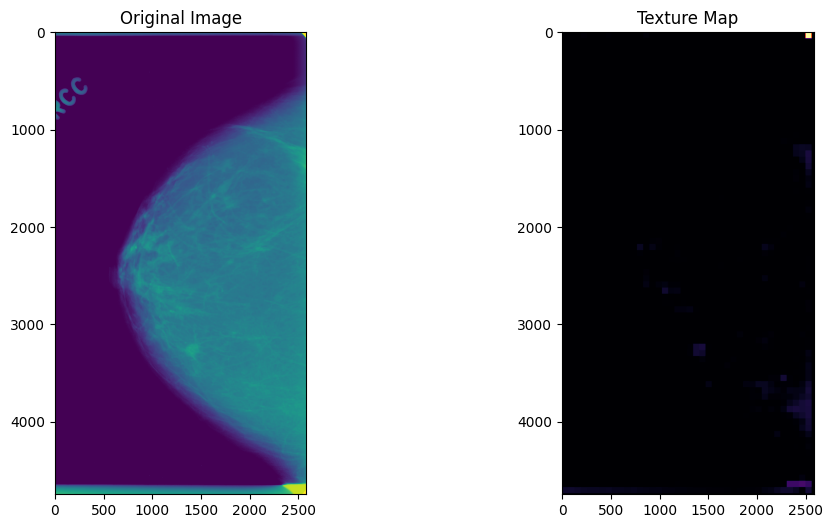

In [47]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util, feature
from skimage.measure import block_reduce
from skimage.feature import graycomatrix, graycoprops

def compute_texture_map(
    image_path: str, 
    chunk_size: int = 64, 
    offsets: tuple = ((1, 0), (0, 1)), 
    haralick_features: list = ['contrast', 'correlation', 'energy', 'homogeneity'],
    downsample: bool = True) -> np.ndarray:
    """
    Compute and plot texture maps of an image in a chunk-wise manner using GLCMs.

    Parameters
    ----------
    image_path : str
        Path to the input image file.
    chunk_size : int, optional
        Size of the chunks to divide the image into (in pixels). Default is 64.
    offsets : tuple, optional
        Offsets of the GLCM calculation. Default is ((1, 0), (0, 1)) for horizontal and vertical directions.
    haralick_features : list, optional
        Haralick texture features to compute for each GLCM. Default is ['contrast', 'correlation', 'energy', 'homogeneity'].
    downsample : bool, optoinal
        Boolean value whether to downsample the image.

    Returns
    -------
    numpy.ndarray
        Texture map of the input image in a chunk-wise manner. The shape of the texture map is (n_rows, n_cols).
    """

    # Load the input image
    image = io.imread(image_path)
    
    # Rescale the image to be between -1 and 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 2 - 1

    # Downsample the image to speed up processing
    if downsample:
        image = util.img_as_ubyte(block_reduce(image, (4, 4), np.mean))
    else:
        image = util.img_as_ubyte(image)
    
    # Determine maximum gray level
    max_gray_level = int(np.max(image))
    
    # Compute the number of chunks in each dimension
    n_rows = image.shape[0] // chunk_size
    n_cols = image.shape[1] // chunk_size
    
    # Create a matrix to store the texture features
    texture_map = np.zeros(image.shape)
    
    # Iterate over each chunk
    for i in range(n_rows):
        for j in range(n_cols):
            
            # Define the coordinates of the current chunk
            row_start = i * chunk_size
            row_end = (i + 1) * chunk_size
            col_start = j * chunk_size
            col_end = (j + 1) * chunk_size
            
            # Extract the current chunk
            chunk = image[row_start:row_end, col_start:col_end]
            
            # Compute the GLCM of the current chunk for each offset and concatenate them
            glcms = []
            for offset in offsets:
                glcm = graycomatrix(chunk, distances=[1], angles=[np.arctan2(offset[0], offset[1])], levels=max_gray_level+1,
                                    symmetric=True, normed=True)
                glcms.append(glcm)
            glcm_concat = np.concatenate(glcms, axis=0)
            
            # Compute the Haralick texture features for the concatenated GLCM
            texture_features = [graycoprops(glcm, feature) for feature in haralick_features for glcm in glcms]
            
            # Store the texture feature in the texture map matrix
            texture_map[row_start:row_end, col_start:col_end] = texture_features[0]
    
    return texture_map

mammogram_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
texture_map = compute_texture_map(mammogram2_path, chunk_size=64, downsample=False)
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(io.imread(mammogram2_path))
ax[0].set_title('Original Image')
ax[1].imshow(texture_map, cmap='inferno')
ax[1].set_title('Texture Map')
plt.show()
######################################################################################################

## Problem 3: Tumor Classification (49 Points)

In addition to the [mammograms themselves (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH), which is based on [this](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Research done about the fields:
- "ground truth": segmentations including precise delination of the location and size of the massess in the mammography done by experienced radiologists. Serves as benchmark for the development and evaluation of automated algorithms for detecting and calssifying breast masses.
- mass shape: the shape of the mass (round, oval, lobular, irregular)
- mass margins: the margins of the mass (circumscribed, microlobulated, obscured, ill-defined, spiculated)
- assessment: BI-RADS assessment code associated with the mass (1-5)
- pathology: the pathology diagnosis for the mass (benign, malignant, high-risk, or uncertain malignant potential)
- subtlety: the level of difficulty in detecting the mass on a scale of 1 to 5, with 1 being the least subtle and 5 being the most subtle.


Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on these feature table using the algorithms presented to you last year in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any package or use your own (custom code, sklearn, keras, Tensorflow, pytorch, timm etc.). If you dont want to place helper functions and classes into this notebook, place them in a .py file in the same folder called helperfunctions.py and import them into this notebook.

The delivery should be a report which includes the experiment planning, the extracted features and the results.
Try answering in your report the following questions:

- Which method(s) did you use?
We used logisitc regression, support vector machines and random forest on a table of automatically extracted features and the features provided by expert radiologist. Additionally, we trained a convolutional neural networks (CNNs) on the mammograms to classify mammograms as malignant or benign. We also used data augmentation on the images to increase the size of our dataset and improve generalization of the CNN.

- Why did you choose these method(s)?
CNNs are well-suited for image classification tasks, and have been shown to perform well on mammogram classification. Data augmentation helps to mitigate overfitting and improve model generalization. On the other hand, classical machine learning algorithms tend to be less complex, more interpretable and less computationally expensive. Logistic regression is the least complex one, trains fast and is a good way to benchmark more complex models. Benchmarking models is important to verify if additional complexity pays off. SVM generally does well in such tasks and has a lot of different hyperparameters which make adjustments of complexity easy. Random forest is a model which has proven to have high generalization power due to it using bagging enhanced by selecting a random subset of predictors for each tree. Due to its characteristics random forest is always worth a try in both classification as well as regression tasks.

- What were your expectations towards these methods?
We expected the CNN model to achieve high accuracy in classifying mammograms as malignant or benign. We also expected that data augmentation would improve model performance. Furthermore, we expected the classical machine learning algorithms to also get quite a good accuracy as the extracted features seemed to give at least some kind of indication whether the tumor is malignant or benign (see task 2). Especially after 'cooperating' with expert radiologists assessments, we expected the results to be even better.

- How did they perform compared to your expectations?
The classical machine learning approaches achieved perfect accuracy after adding the expert radiologists descriptions of the lesions. The CNN model achieved decent accuracy but did not reach the level of accuracy we were hoping for. Data augmentation helped to improve performance but did not completely eliminate overfitting. Additionally, the CNN showed increasing accuracy on training and evaluation set but the loss for the validation set kept increasing and hardly decreased on the training set. Although there need not be a clear relationship between binary cross-entropy (bce) and accuracy with the size of the data set we have, we still did not expect that. We thought there might be a huge outlier in the test data which leads to one big loss value, which increases the bce in the end as it is an average of all the losses in a batch. This was not the case, though, as can be seen in the histogram of the losses.

- Which metrics did you use? To which ones did you pay the most attention?
We used accuracy, precision, recall, and F1 score to evaluate model performance. We paid the most attention to F1 score and recall. F1 provides a balance between precision and recall, while the recall is even more important then the rest as the main goal in medical image classification is to minimize false negatives (classifying malignant tumors as benign). Recall is defined as the ratio of true positives to the sum of true positives and false negatives, so it reflects the ability of the model to correctly identify positive cases. For the CNN we only monitored accuracy, which the model tried to maximize and binary cross-entropy as a loss function as we have dealt with a binary classification task.

- How do you feel about your results?
We feel that the results are satisfactory but not optimal. For the classical machine learning approaches, more data should be gathered, as merging the features of the images with the labels and mass descriptions lead to a decrease in number of observations of around 50%. Thus, only around 750 samples were left. Although it was apparently more than enough to achieve good results, more data should always be the aim. That way one can also test on more data. So, there is still room for improvement, especially in the deep-learning approach. One can still put efforts in reducing overfitting and improving accuracy. Nevertheless, trying out all the possibilities is out of scope for this course.

- How would you plan to improve your results further?
To improve results further, we could try increasing the size of our dataset, using more advanced data augmentation techniques, and fine-tuning the model architecture and hyperparameters. We could also try ensembling multiple models or using transfer learning. Additionally, we could explore alternative feature extraction methods or preprocessing steps to improve the quality of the input data.

In [ ]:
# ----------------------- APPROACH 1: CLASSICAL MACHINE LEARNING ALGORITHMS -----------------------

In [350]:
# ----------------------- Define Functions to extract features and store them into one data frame -----------------------
import os
import numpy as np
import pandas as pd
from skimage import io, color, feature, filters, measure
from scipy import ndimage

# Define a function to extract features from an image
import numpy as np
from skimage import feature, filters, measure
from scipy import ndimage


# Define a function to extract features from a set of images and return a pandas dataframe
def extract_features_to_dataframe(image_dir):
    geometric_features = dict()
    # Extract features for each image in the image directory
    features_list = []
    filenames_list = []
    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith('.tif'):
            # Load the image
            ind = filename.split('.tif')[0]
            mammogram_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)
            
            geometric_features[ind] = extract_features(mammogram_path, mask_path)
            
    return geometric_features

# Redefine exctract_features function to reduce calculation time and number of features
from skimage import io, measure, filters
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import fft2, fftshift
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import pywt

def extract_features(mammogram_path: str, mask_path: str):
    """
    Extracts geometric and texture features from two mammograms and their corresponding masks.

    Parameters:
        mammogram_path (str): The file path of the first mammogram.
        mask_path (str): The file path of the mask for the first mammogram.

    Returns:
        Dictionary containing the following features for each mammogram:
        - Area
        - Perimeter
        - Eccentricity
        - Solidity
        - Haralick texture features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        - Gabor filter features: mean, variance, skewness, kurtosis
        - Wavelet features: standard deviation of coefficients for each level
        - Fourier Transform features: mean, variance, skewness, kurtosis, and energy from the magnitude spectrum
    """

    # Load the mammograms and masks
    mammogram = io.imread(mammogram_path)
    mask = io.imread(mask_path)
    
    # Rescale image
    mammogram, mask = [rescale_image(img) for img in [mammogram, mask]]
    
    # Create a binary mask of the lesion by thresholding the mask
    lesion = np.zeros_like(mammogram)
    lesion[mask > 0] = mammogram[mask > 0]

    # Compute geometric features using regionprops
    props = measure.regionprops(mask, intensity_image=mammogram)

    features = {}

    for i in range(len(props)):
        # Extract geometric features
        area, perimeter, eccentricity, solidity = props[i].area, props[i].perimeter, props[i].eccentricity, props[i].solidity
        features = {f'area{i}': area, f'perimeter{i}': perimeter, f'eccentricity{i}': eccentricity, f'solidity{i}': solidity}

    # Apply Gabor filter and calculate its features
    freq = 0.5
    theta = np.pi/4
    gabor = filters.gabor(lesion, frequency=freq, theta=theta)[0]
    mean, var, _skew, kurt = np.mean(gabor), np.var(gabor), skew(gabor.flatten()), kurtosis(gabor.flatten())
    features[f'gabor_mean_freq{freq}_theta{theta}'] = mean
    features[f'gabor_var_freq{freq}theta{theta}'] = var
    features[f'gabor_skew_freq{freq}theta{theta}'] = _skew
    features[f'gabor_kurtosis_freq{freq}theta{theta}'] = kurt

    # Apply 2D wavelet transform and calculate its features
    # extract approximation (cA), horizontal detail (cH), vertical detail (cV), and diagonal detail (cD)
    coeffs = pywt.dwt2(lesion, 'db2')
    cA, (cH, cV, cD) = coeffs
    features['wavelet_cA_mean'] = np.mean(cA)
    features['wavelet_cA_var'] = np.var(cA)
    features['wavelet_cH_mean'] = np.mean(cH)
    features['wavelet_cH_var'] = np.var(cH)
    features['wavelet_cV_mean'] = np.mean(cV)
    features['wavelet_cV_var'] = np.var(cV)
    features['wavelet_cD_mean'] = np.mean(cD)
    features['wavelet_cD_var'] = np.var(cD)

    # Perform Fourier Transform
    f = np.fft.fft2(mammogram)
    fshift = np.fft.fftshift(f)

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate texture features from the magnitude spectrum
    mean_spectrum = np.mean(magnitude_spectrum)
    var_spectrum = np.var(magnitude_spectrum)
    skew_spectrum = np.mean((magnitude_spectrum-mean_spectrum)**3)/(np.mean((magnitude_spectrum-mean_spectrum)**2)**1.5)
    kurtosis_spectrum = np.mean((magnitude_spectrum-mean_spectrum)**4)/(np.mean((magnitude_spectrum-mean_spectrum)**2)**2)
    energy_spectrum = np.sum(magnitude_spectrum**2)/np.size(magnitude_spectrum)

    features['mean_spectrum'] = mean_spectrum
    features['var_spectrum'] = var_spectrum
    features['skew_spectrum'] = skew_spectrum
    features['kurtosis_spectrum'] = kurtosis_spectrum
    features['energy_spectrum'] = energy_spectrum

    return features

In [92]:
# ----------------------- Extract Features of all images -----------------------
labels_dir = 'data\\labels.csv'
data_dirs = ['data\\imgs_0', 'data\\imgs_1', 'data\\imgs_2']
mask_dir = 'data\\masks'
# ----------------------- Calculate Geometric Features Table for all Mammograms -----------------------
# Load the labels file
labels_df = pd.read_csv(labels_dir, sep=';', index_col=0)
imgs0 = extract_features_to_dataframe(data_dirs[0])
imgs1 = extract_features_to_dataframe(data_dirs[1])
imgs2 = extract_features_to_dataframe(data_dirs[2])
# Merge features of all images
data_set = pd.DataFrame(imgs0).T.append(pd.DataFrame(imgs1).T).append(pd.DataFrame(imgs2).T)
# Save final data_set
data_set.to_csv('features_table.csv')

In [122]:
# ----------------------- Add Mass Descriptions -----------------------
# Read data
data_set = pd.read_csv('features_table.csv', index_col=0)
mass_case_descr = pd.read_csv('data\\mass_case_description_train_set.csv')
# Get filenames
mass_case_descr['filename'] = mass_case_descr['image file path'].apply(lambda x: x.split('Mass-Training_')[1].split('/')[0])
# mass_case_descr['abnormality type'].value_counts()
# Define relevant columns
feature_columns = ['filename', 'mass shape', 'mass margins', 'assessment', 'subtlety']
# Subset data
mass_case_descr = mass_case_descr[feature_columns]
# Merge data
mass_descr_labeled = pd.merge(mass_case_descr, labels_df, left_on='filename', right_index=True)
mass_descr_labeled = mass_descr_labeled.set_index('filename')
data_set_labeled = pd.merge(data_set, mass_descr_labeled, left_index=True, right_index=True)
# Save data
data_set_labeled.dropna().to_csv('features_with_descr_labels.csv')

In [124]:
# ----------------------- Machine Learning Algorithms -----------------------
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ----------------------- Load Data -----------------------
merged_df = pd.read_csv('features_with_descr_labels.csv', index_col=0)
# One-Hot Encode data
merged_df = pd.get_dummies(merged_df, columns=['mass shape', 'mass margins'])
# ----------------------- Train Models -----------------------

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_df.drop(merged_df.columns[-1], axis=1), merged_df['label'], test_size=0.1, random_state=42)

# Define the features and label columns
feature_cols = merged_df.columns[:-1]
label_col = 'label'

# Compute the class distribution
class_dist = merged_df['label'].value_counts(normalize=True)

print("Class distribution:")
print(class_dist)
# Remove highly correlated variables
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
feature_cols = X_train.columns[:-1]
print(f'Dropped columns due to high correlation: {to_drop}')

# Remove multicollinearity using the VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
while vif['VIF Factor'].max() > 5:
    max_vif_index = vif['VIF Factor'].idxmax()
    feature_to_drop = vif.loc[max_vif_index, 'features']
    X_train = X_train.drop(columns=[feature_to_drop])
    X_test = X_test.drop(columns=[feature_to_drop])
    feature_cols = X_train.columns
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["features"] = X_train.columns
    if len(feature_to_drop) > 0:
        print(f'Dropped columns due to multi-collinearity: {feature_to_drop}')

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA on the training data and transform the data
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Get the number of principal components
n_components = X_train_pca.shape[1]

print("Number of principal components:", n_components)

# Define the models to train and their hyperparameters to tune
models = [
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'hyperparameters': {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga'],
            'max_iter': [100, 200, 500]
        }
    },
    {
        'name': 'SVM',
        'estimator': SVC(),
        'hyperparameters': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4]
        }
    },
    {
        'name': 'Random Forest Classifier',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy']
        }
    }
]



Class distribution:
1    0.5
0    0.5
Name: label, dtype: float64
Dropped columns due to high correlation: ['gabor_var_freq0.5theta0.7853981633974483', 'gabor_kurtosis_freq0.5theta0.7853981633974483', 'wavelet_cA_var', 'wavelet_cV_var', 'wavelet_cD_var', 'energy_spectrum']
Dropped columns due to multi-collinearity: mass shape_OVAL
Dropped columns due to multi-collinearity: mean_spectrum
Dropped columns due to multi-collinearity: kurtosis_spectrum
Dropped columns due to multi-collinearity: perimeter0
Dropped columns due to multi-collinearity: gabor_mean_freq0.5_theta0.7853981633974483
Dropped columns due to multi-collinearity: solidity0
Dropped columns due to multi-collinearity: var_spectrum
Dropped columns due to multi-collinearity: wavelet_cA_mean
Dropped columns due to multi-collinearity: gabor_skew_freq0.5theta0.7853981633974483
Dropped columns due to multi-collinearity: subtlety
Dropped columns due to multi-collinearity: eccentricity0
Dropped columns due to multi-collinearity: asse

In [125]:
# Train and evaluate each model using k-fold cross-validation
results = []
for model in models:
    print(f"Training {model['name']}...")
    estimator = model['estimator']
    hyperparameters = model['hyperparameters']
    
    # Use GridSearchCV to find the best hyperparameters
    grid = GridSearchCV(estimator, hyperparameters, scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    
    # Train the model with the best hyperparameters
    estimator.set_params(**grid.best_params_)
    estimator.fit(X_train_pca, y_train)
    
    # Evaluate the model on the test set
    test_pred = estimator.predict(X_test_pca)
    test_acc = accuracy_score(y_test, test_pred)
    test_prec = precision_score(y_test, test_pred)
    test_rec = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Store the results in a dictionary
    result = {
        'model': model['name'],
        'best_params': grid.best_params_,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1
    }
    results.append(result)

# Convert the results to a pandas dataframe
results_df = pd.DataFrame(results)

# Save the results dataframe to a CSV file
results_df.to_csv("model_results.csv", index=False)
print('Finished training')
print(results_df)

Training Logistic Regression...
Training SVM...
Training Random Forest Classifier...
Finished training
                      model  \
0       Logistic Regression   
1                       SVM   
2  Random Forest Classifier   

                                         best_params  test_accuracy  \
0  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...       1.000000   
1  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...       1.000000   
2  {'bootstrap': True, 'criterion': 'gini', 'max_...       0.985915   

   test_precision  test_recall   test_f1  
0             1.0      1.00000  1.000000  
1             1.0      1.00000  1.000000  
2             1.0      0.97619  0.987952  


In [37]:
# ----------------------- APPROACH 2: CONVOLUTIONAL NEURAL NETWORK -----------------------
# ----------------------- Create custom generator -----------------------
# Set Up
from typing import List, Tuple
import numpy as np
import random

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from skimage import io, exposure, filters

# Define rescaling function again
def rescale_image(img: np.ndarray) -> np.ndarray:
    """
    Rescale an image so that the maximum grayscale value is 255.

    Args:
        img: A NumPy array representing the image.

    Returns:
        A rescaled NumPy array representing the image.
    """
    max_val = np.max(img)
    img_rescaled = (img / max_val) * 255
    img_rescaled = img_rescaled.astype(np.uint8)
    return img_rescaled

# Define the data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    # zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    # brightness_range=[0.5, 1.5]
)

# Define custom data generator to load one image at a time during training
def data_generator(filenames: List[str], labels: np.ndarray, batch_size: int, num_classes: int) -> Tuple[np.ndarray, np.ndarray]:
    """Custom data generator to load and preprocess mammogram images in batches.
    
    Args:
        filenames (List[str]): List of file paths to the mammogram images.
        labels (np.ndarray): Array of labels for the mammogram images.
        batch_size (int): Batch size.
        num_classes (int): Number of classes.
        
    Yields:
        Tuple[np.ndarray, np.ndarray]: A tuple of batched images and corresponding labels.
    """
    while True:
        # Shuffle the filenames and labels
        data = list(zip(filenames, labels))
        random.shuffle(data)
        filenames, labels = zip(*data)

        # Loop over the filenames and load the corresponding images
        for i in range(0, len(filenames), batch_size):
            batch_filenames = filenames[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            for filename in batch_filenames:
                image = Image.open(filename).resize((256, 256))
                # Perform any necessary preprocessing on the image here
                # Normalize the images
                image = rescale_image(np.array(image))
                # Apply Gaussian smoothing
                image = filters.gaussian(image, sigma=1)
                image = np.expand_dims(image, axis=-1)
                # Append images
                batch_images.append(image)
            # Convert the list of images to a numpy array
            batch_images = np.array(batch_images)
            # Convert the labels to a numpy array
            batch_labels = np.expand_dims(batch_labels, axis=-1)  # add new axis

            # Apply data augmentation to the batch
            batch_images, batch_labels = next(train_datagen.flow(batch_images, batch_labels, batch_size=batch_size))

            yield batch_images, batch_labels


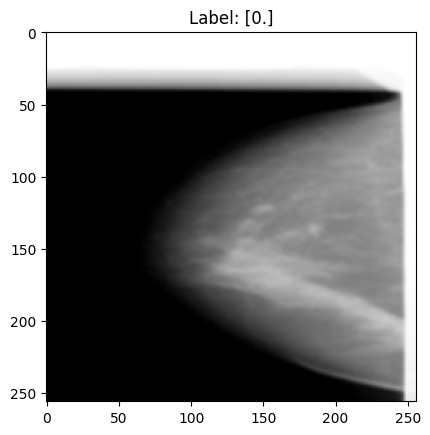

In [36]:
# ----------------------- Visualize Output of Generator -----------------------
import matplotlib.pyplot as plt
# Example usage to display a sample image
batch_size = 16
train_gen = data_generator(X_train, y_train, batch_size=batch_size, num_classes=2)

# Get the first batch of images and corresponding labels
batch_images, batch_labels = next(train_gen)

# Display the first image in the batch
plt.imshow(batch_images[0][:,:,0], cmap='gray')
plt.title(f'Label: {batch_labels[0][0]}')
plt.show()

# print(batch_labels)

In [44]:
# ----------------------- Train CNN that learns complex features itself -----------------------
import os
import pandas as pd

from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# ----------------------- Prepare Data -----------------------
# Load the mammogram data and labels
mammograms = []
labels = []
df = pd.read_csv('data\\labels.csv', sep=';')

# Get a list of the image filenames
filenames = os.listdir('data\\imgs_0') + os.listdir('data\\imgs_1') + os.listdir('data\\imgs_2')
filenames = [f.split('.tif')[0] for f in filenames]

# Subset the labels dataframe to only include those with filenames in the image directory
df = df[df['name'].isin(filenames)]

# Loop over the directories containing the images
for directory in ['data\\imgs_0', 'data\\imgs_1', 'data\\imgs_2']:
    # Get a list of the image filenames in the directory
    directories = os.listdir(directory)
    directories = [ directory + '\\' + d for d in directories]
    filenames = [f.split('.tif')[0].split('\\')[2] for f in directories]

    # Subset the labels dataframe to only include those with filenames in the current directory
    df_subset = df[df['name'].isin(filenames)]

    # Loop over the remaining rows in the labels dataframe and save the paths of the corresponding mammogram images
    for idx, row in df_subset.iterrows():
        filename = row['name']
        label = row['label']
        mammograms.append( directory + '\\' + filename + '.tif')
        labels.append(label)

# Encode the labels as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(mammograms, labels, test_size=0.1, random_state=42)

# Convert the labels to categorical format
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# ----------------------- Define CNN Architecture & Generators -----------------------
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
model.add(Flatten())

# Define the optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.00001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
# ----------------------- Train Model -----------------------
# define the batch size and number of epochs
batch_size = 16
epochs = 10

# Define the data augmentation generator
train_gen = data_generator(X_train, y_train, batch_size=batch_size, num_classes=2)
val_gen = data_generator(X_test, y_test, batch_size=batch_size, num_classes=2)

# define the model checkpoint to save the best model weights
checkpoint = ModelCheckpoint('cnn_lower_lr.h5', save_best_only=True, save_weights_only=True, mode='auto', verbose=1)

# Fit the model using the custom data generator
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(X_test) // batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.69323, saving model to cnn_lower_lr.h5
63/63 [==============================] - 138s 2s/step - loss: 0.6932 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.0388
Epoch 2: val_loss did not improve from 0.69323
63/63 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.0388 - val_loss: 0.6939 - val_accuracy: 0.0357
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.0765
Epoch 3: val_loss did not improve from 0.69323
63/63 [==============================] - 136s 2s/step - loss: 0.6928 - accuracy: 0.0765 - val_loss: 0.6937 - val_accuracy: 0.0982
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.3290
Epoch 4: val_loss did not improve from 0.69323
6

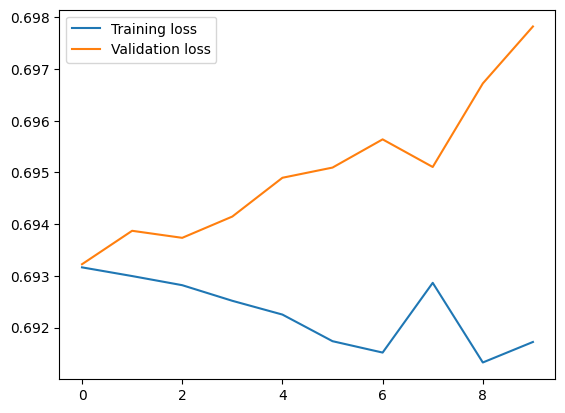

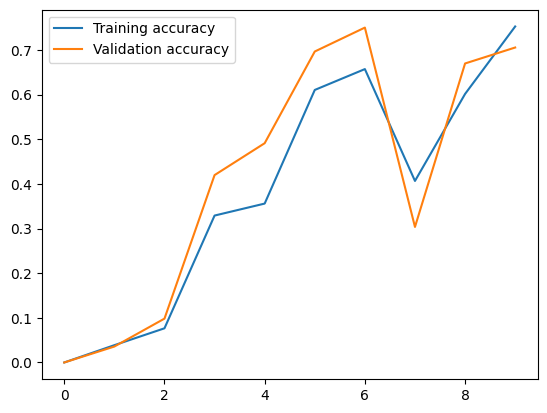

In [56]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:36<00:00,  2.49s/it]


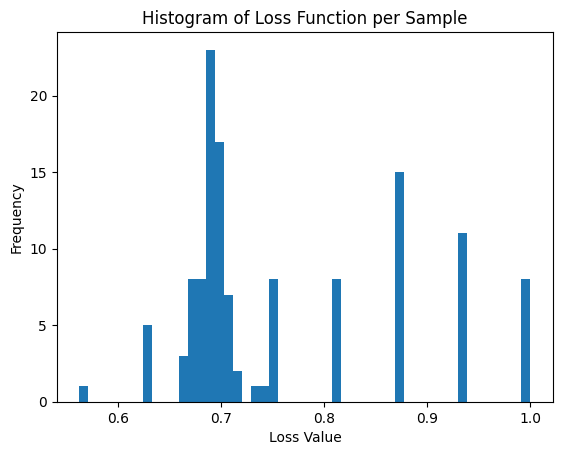

In [61]:
# Collect loss values per sample during training to detect potential outliers in loss
loss_per_sample = []
train_gen = data_generator(X_train, y_train, batch_size=batch_size, num_classes=2)
for i in tqdm(range(len(X_train) // batch_size)):
    # Get the next batch of training data
    x_batch, y_batch = next(train_gen)
    # Compute the loss for each sample in the batch
    loss_batch = model.train_on_batch(x_batch, y_batch)
    # Add the loss values to the list
    loss_per_sample.extend(loss_batch)

# Create histogram plot of loss values
plt.hist(loss_per_sample, bins=50)
plt.title("Histogram of Loss Function per Sample")
plt.xlabel("Loss Value")
plt.ylabel("Frequency")
plt.show()